In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler as dc
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix
from kneed import KneeLocator

import magic

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=100
)

In [2]:
# read anndata
adata = sc.read_h5ad(
 'data/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad'
)

# CP10k normalization total
sc.pp.normalize_total(adata, layer = 'counts',  target_sum=1e4)
sc.pp.log1p(adata)

AnnData object with n_obs × n_vars = 86447 × 37733
    obs: 'barcode', 'library', 'total_counts', 'pct_counts_mito', 'BC3', 'BC2', 'BC1', 'rnaseh', 'rt_condition', 'maxima', 'tso', 'gtp', 'rt_condition_rnaseh', 'sample_code', 'sample', 'code', 'doublet_score', 'n_counts', 'cell_type_old_1', 'leiden_1.4_sub', 'cell_type_old_2', 'n_genes_by_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden_2.5_sub', 'leiden_2.5', 'cell_type_t', 'leiden_1.0_sub_t', 'cell_type_neutrophils', 'leiden_1.0_sub_neutrophils', 'cell_type_aml', 'leiden_1.0_sub_aml', 'cell_type', 'cell_type_refined'
    var: 'mt', 'ribo'
    uns: 'cell_type_old_2_colors', 'hvg', 'leiden_2.5_sub_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'var'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [3]:
# run NMF
nmf_model = NMF(n_components=25, random_state=42, max_iter=1000)
W = nmf_model.fit_transform(adata.X)
H = nmf_model.components_

# add to anndata
adata.obsm['X_nmf'] = W
adata.varm['features_nmf'] = H.T


In [7]:
# extract the gene scores
gene_scores = adata.varm['features_nmf']

# convert to a data frame
gene_scores_df = pd.DataFrame(
    gene_scores,
    index=adata.var_names,  # Gene names
    columns=[f"F_{i+1}" for i in range(gene_scores.shape[1])]
)

# add gene scores to adata.var
adata.var = pd.concat([adata.var, gene_scores_df], axis=1)

# convert to a data frame
nmf_factors = pd.DataFrame(
    adata.obsm['X_nmf'],
    index=adata.obs_names,
    columns=[f"F_{i+1}" for i in range(adata.obsm['X_nmf'].shape[1])]
)
# add cell scores to adata.obs
adata.obs = pd.concat([adata.obs, nmf_factors], axis=1)

# add UMAP dims to obs
adata.obs['UMAP_1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP_2'] = adata.obsm['X_umap'][:, 1]

In [8]:
# create a dictionary
top_genes_per_factor = {}

# iterate over each factor
for factor in gene_scores_df.columns:
    # sort genes by their score
    top_genes = gene_scores_df[[factor]].nlargest(50, factor)
    top_genes.index.name = 'gene_symbol'
    top_genes.rename(columns={factor: 'score'}, inplace=True)
    
    # store in dictionary
    top_genes_per_factor[factor] = top_genes


In [9]:
# list to store factors
factors_with_gene = []

# iterate through each factor
for factor, top_genes in top_genes_per_factor.items():
    if 'MIR181A1HG' in top_genes.index:
        factors_with_gene.append(factor)

factors_with_gene

['F_3', 'F_4', 'F_9', 'F_11']

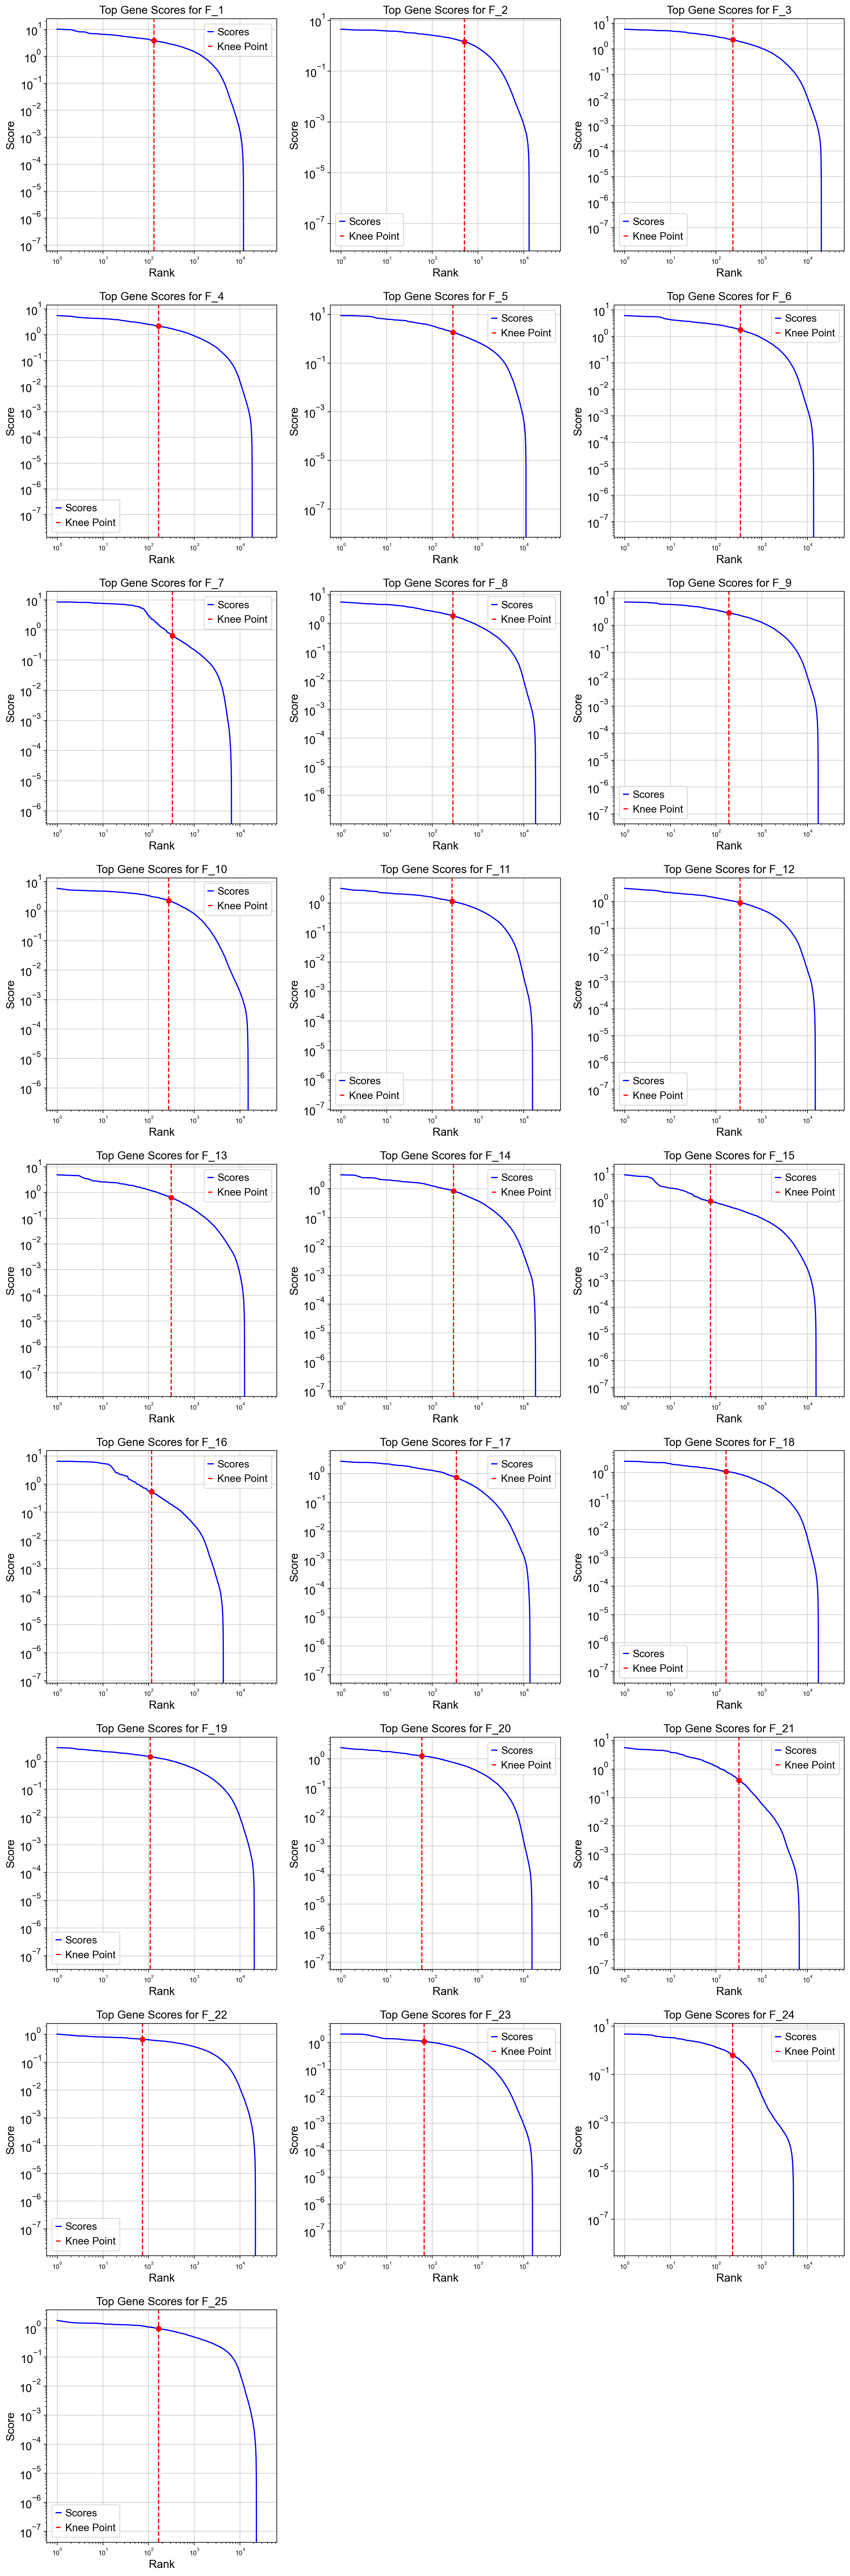

F_1: Selected 131 genes
F_2: Selected 505 genes
F_3: Selected 235 genes
F_4: Selected 164 genes
F_5: Selected 284 genes
F_6: Selected 339 genes
F_7: Selected 332 genes
F_8: Selected 284 genes
F_9: Selected 190 genes
F_10: Selected 274 genes
F_11: Selected 270 genes
F_12: Selected 337 genes
F_13: Selected 313 genes
F_14: Selected 289 genes
F_15: Selected 76 genes
F_16: Selected 117 genes
F_17: Selected 334 genes
F_18: Selected 166 genes
F_19: Selected 108 genes
F_20: Selected 59 genes
F_21: Selected 316 genes
F_22: Selected 73 genes
F_23: Selected 66 genes
F_24: Selected 231 genes
F_25: Selected 166 genes


In [10]:
# dict to store
knee_genes_per_factor = {}

num_factors = len(gene_scores_df.columns)
panels_per_row = 3
num_rows = (num_factors + panels_per_row - 1) // panels_per_row
fig, axes = plt.subplots(num_rows, panels_per_row, figsize=(15, 5 * num_rows), sharex=False)
axes = axes.flatten()

# iterate over each factor
for i, (factor, ax) in enumerate(zip(gene_scores_df.columns, axes)):
    
    # sort genes by their scores
    sorted_genes = gene_scores_df[[factor]].sort_values(by=factor, ascending=False)

    # prepare x (rank) and y (score) for KneeLocator
    x = range(1, len(sorted_genes) + 1)
    y = sorted_genes[factor].values

    # apply KneeLocator
    kneedle = KneeLocator(x, y, S=0.85, curve="convex", direction="decreasing")
    knee_point = kneedle.knee or len(sorted_genes)  # Use full length if no knee is found

    # select genes up to the knee point
    knee_genes = sorted_genes.iloc[:knee_point].copy()
    knee_genes.index.name = 'gene_symbol'
    knee_genes.rename(columns={factor: 'score'}, inplace=True)

    # store in dict
    knee_genes_per_factor[factor] = knee_genes

    # plot
    ax.plot(x, y, linestyle='-', label="Scores", color="blue")
    if kneedle.knee:
        ax.axvline(kneedle.knee, color='red', linestyle='--', label="Knee Point")
        ax.scatter(kneedle.knee, y[kneedle.knee - 1], color='red', zorder=5)
    ax.set_title(f"Top Gene Scores for {factor}")
    ax.set_xlabel("Rank")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel("Score")
    ax.legend()
    ax.tick_params(axis='x', labelsize=8)

# Hide any unused axes
for j in range(len(gene_scores_df.columns), len(axes)):
    axes[j].axis('off')

# adjust layout
plt.tight_layout()
plt.show()

# check the results
for factor, genes in knee_genes_per_factor.items():
    print(f"{factor}: Selected {len(genes)} genes")


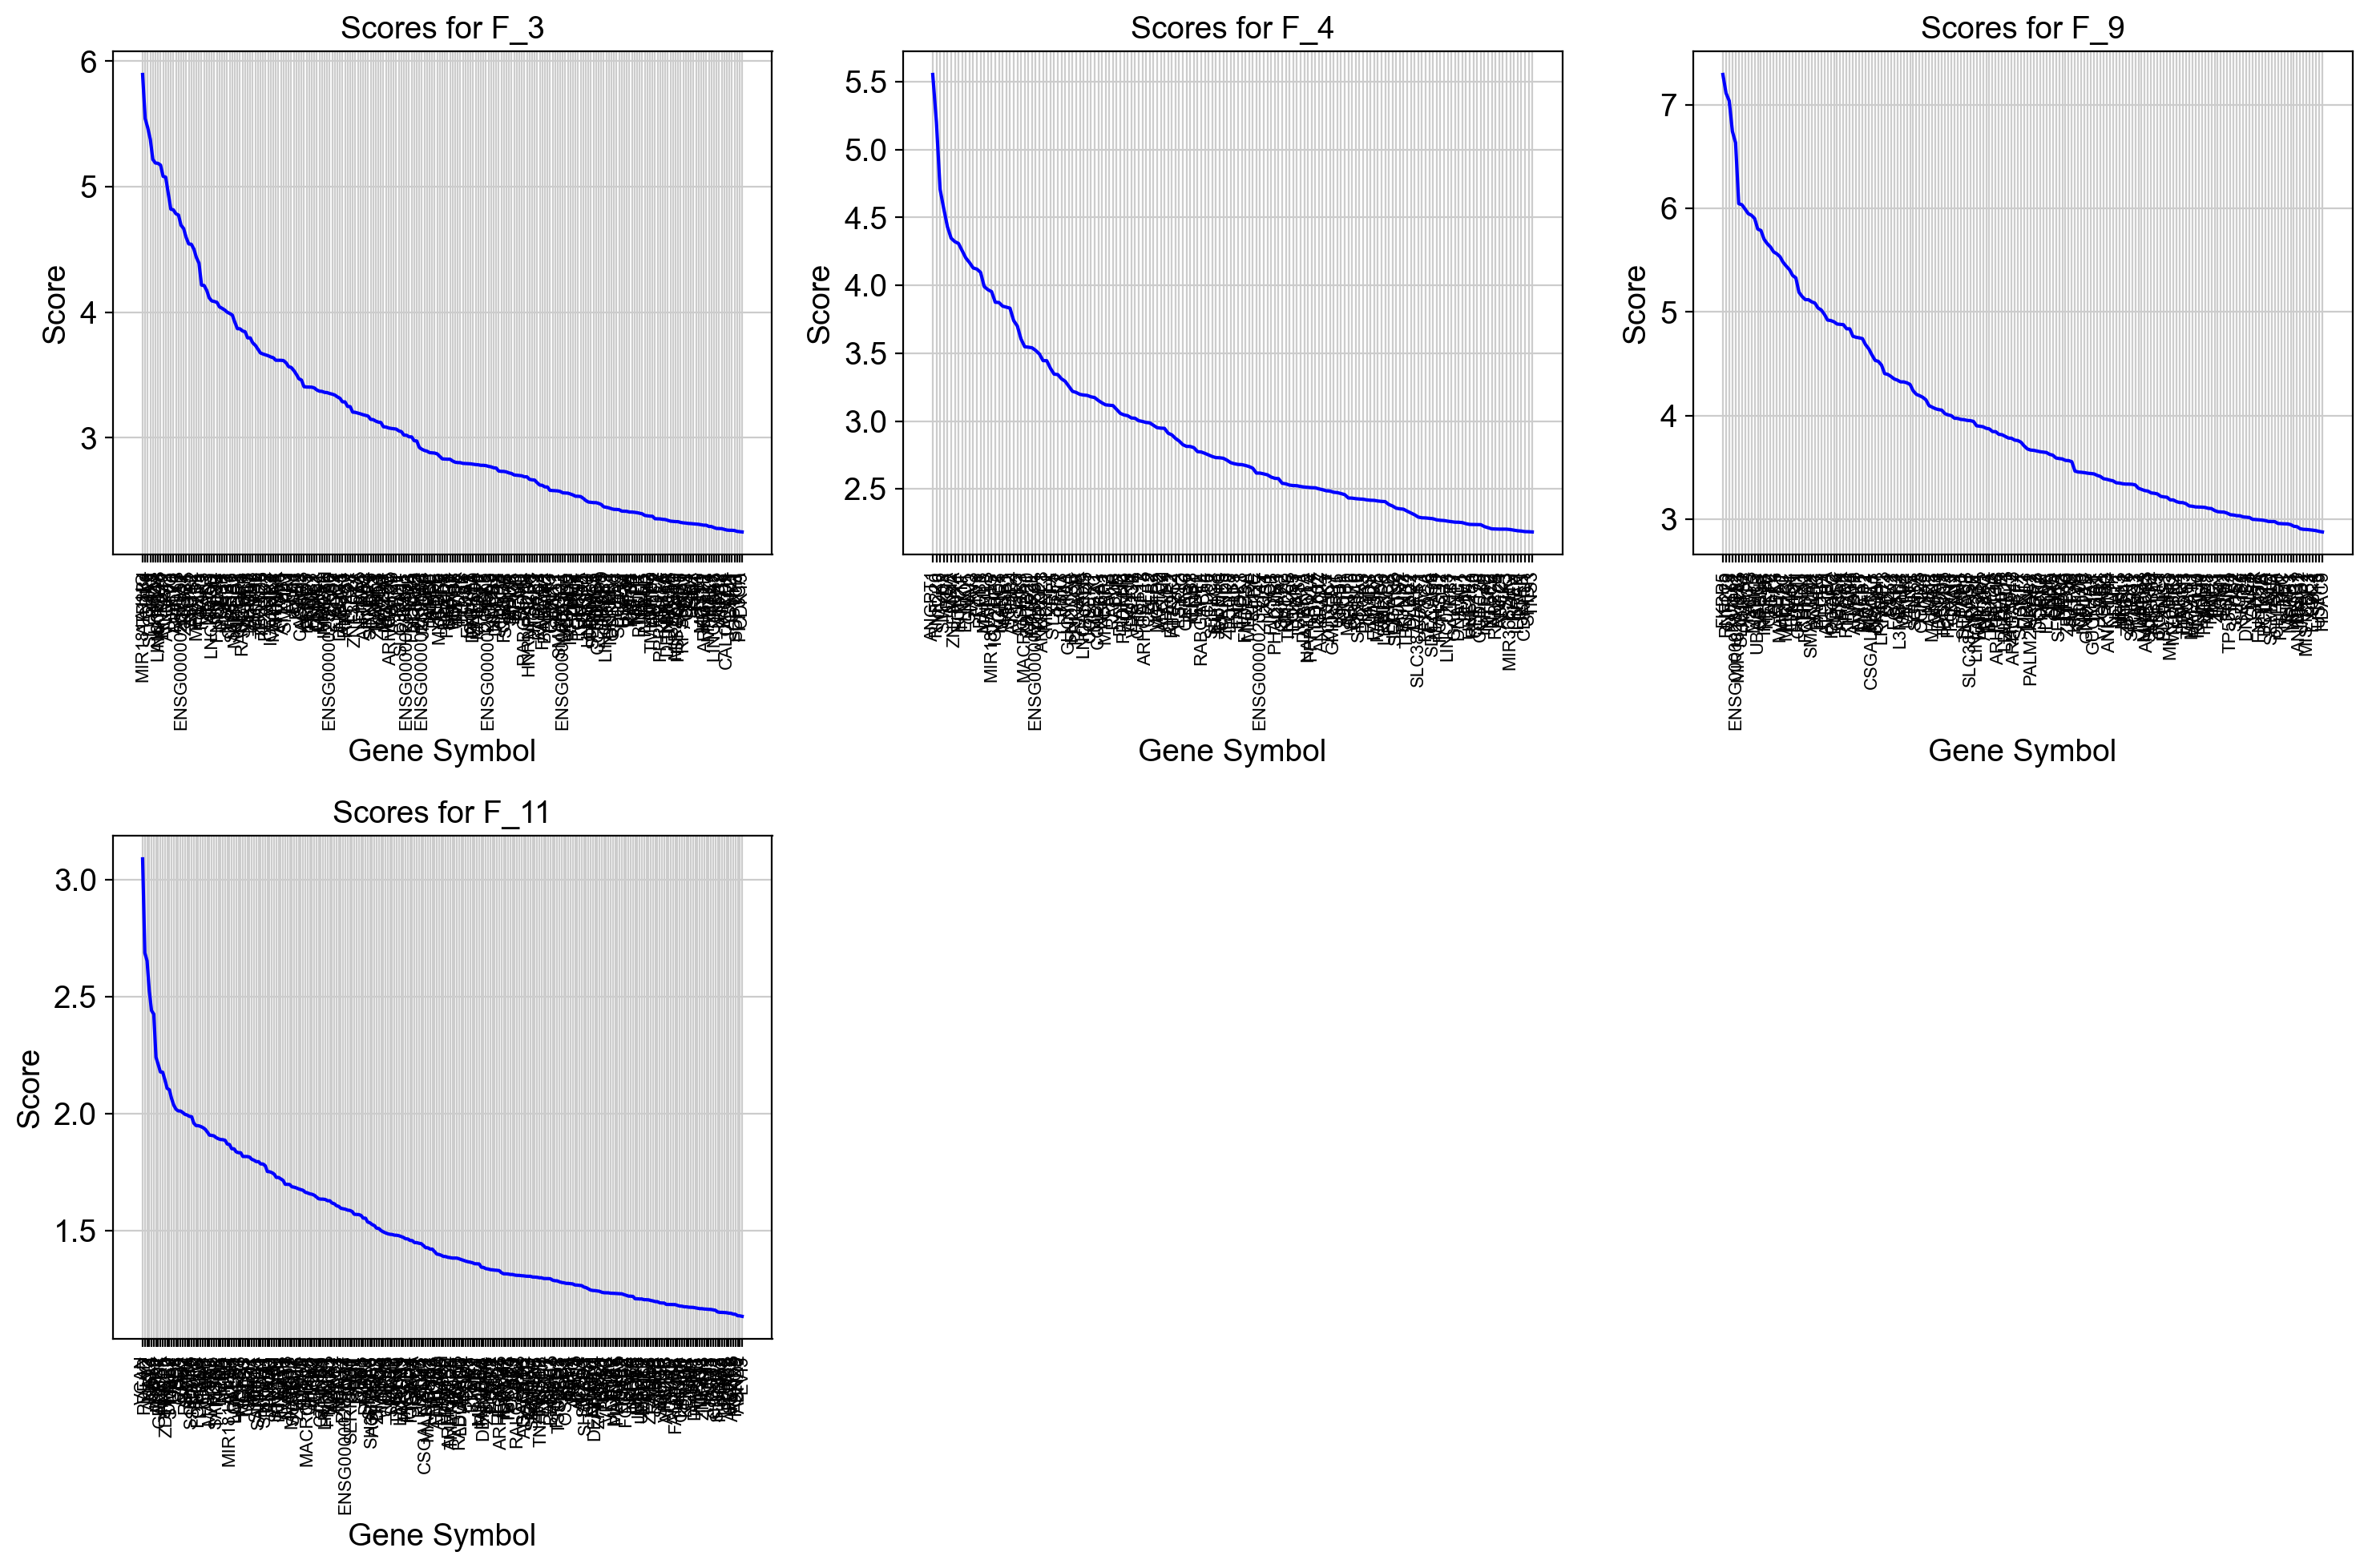

In [11]:
# list to store factors
factors_with_knee_gene = []

# Iterate through each factor
for factor, top_genes in knee_genes_per_factor.items():
    if 'MIR181A1HG' in top_genes.index:
        factors_with_knee_gene.append(factor)

# filter the dictionary
knee_genes_per_factor_mir = {
    factor: knee_genes_per_factor[factor] for factor in factors_with_knee_gene
}

# plot for factors with MIR181A1HG
num_selected_factors = len(factors_with_knee_gene)
panels_per_row = 3
num_rows = (num_selected_factors + panels_per_row - 1) // panels_per_row
fig, axes = plt.subplots(num_rows, panels_per_row, figsize=(15, 5 * num_rows), sharex=False)
axes = axes.flatten()

for i, (factor, ax) in enumerate(zip(factors_with_knee_gene, axes)):
    top_genes = knee_genes_per_factor[factor]
    ax.plot(top_genes.index, top_genes['score'], linestyle='-', label=f"{factor} Scores", color="blue")
    ax.set_title(f"Scores for {factor}")
    ax.set_xlabel("Gene Symbol")
    ax.set_ylabel("Score")
    ax.tick_params(axis='x', rotation=90, labelsize=8)

# Hide any unused axes
for j in range(len(factors_with_knee_gene), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


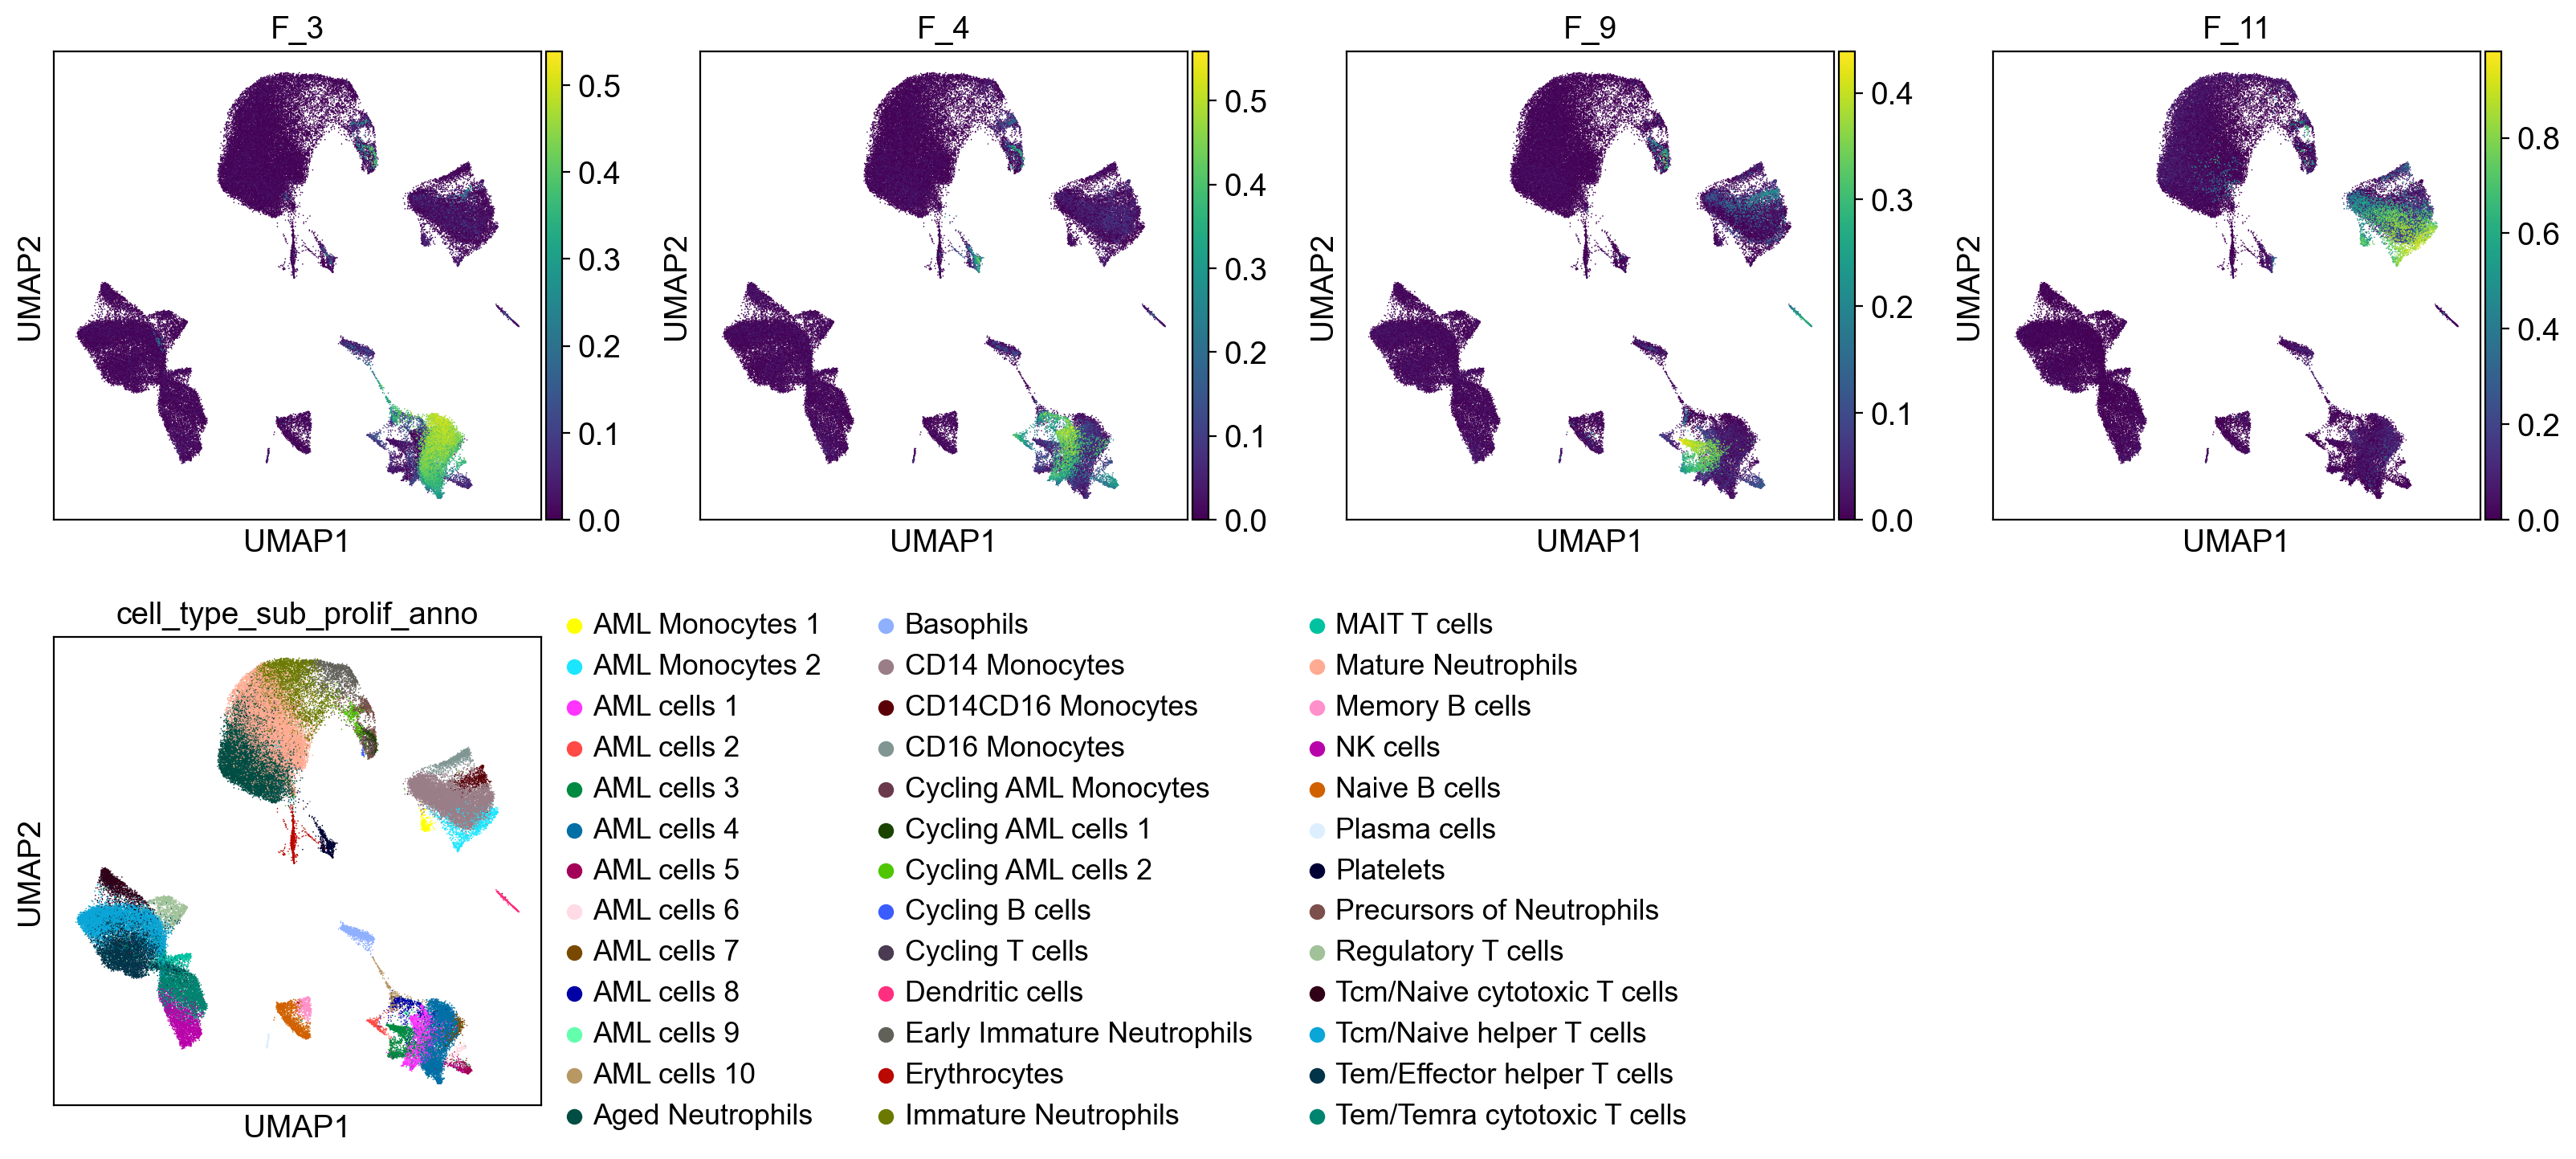

In [13]:
# plot UMAP colored by these factors
sc.pl.umap(
    adata,
    color= factors_with_knee_gene + ['cell_type_sub_prolif_anno'],
    save = 'nmf_latent_factors.png'
)

In [14]:
# Retrieve MSigDB resource
msigdb = dc.get_resource('MSigDB')

msigdb['collection'].unique().tolist()

['chemical_and_genetic_perturbations',
 'immunesigdb',
 'mirna_targets_mirdb',
 'go_molecular_function',
 'tf_targets_gtrf',
 'tf_targets_legacy',
 'oncogenic_signatures',
 'cell_type_signatures',
 'vaccine_response',
 'go_biological_process',
 'cancer_gene_neighborhoods',
 'cancer_modules',
 'go_cellular_component',
 'wikipathways',
 'reactome_pathways',
 'hallmark',
 'mirna_targets_legacy',
 'biocarta_pathways',
 'positional',
 'human_phenotype_ontology',
 'pid_pathways',
 'kegg_pathways']

In [15]:
# init a dictionary
collection_ora_results = {}

# collections to iterate over
collections = [
    'go_biological_process',
    'hallmark'
]

# iterate through each collection
for collection in collections:
    
    # filter the msigdb
    filtered_net = msigdb[msigdb['collection'] == collection]
    
    # remove duplicated entries
    filtered_net = filtered_net[~filtered_net.duplicated(['geneset', 'genesymbol'])]
    
    ora_results = {}
    aggregated_top_genes = []
    
    # iterate through each latent factor and its top genes table
    for factor, top_genes in knee_genes_per_factor_mir.items():
        # run ORA for the top genes
        enr_pvals = dc.get_ora_df(
            df=top_genes,
            net=filtered_net,
            source='geneset',
            target='genesymbol',
            n_background=30000
        )
        
        # store results
        ora_results[factor] = enr_pvals
        
        # add the aggregated list
        aggregated_top_genes.append(top_genes)
    
    # concatenate
    aggregated_top_genes_df = pd.concat(aggregated_top_genes)
    
    # run ORA analysis on the aggregated top genes
    aggregated_enr_pvals = dc.get_ora_df(
        df=aggregated_top_genes_df,
        net=filtered_net,
        source='geneset',
        target='genesymbol'
    )
    
    # store the aggregated results
    ora_results["aggregated"] = aggregated_enr_pvals
    
    # store the results for the current collection
    collection_ora_results[collection] = ora_results


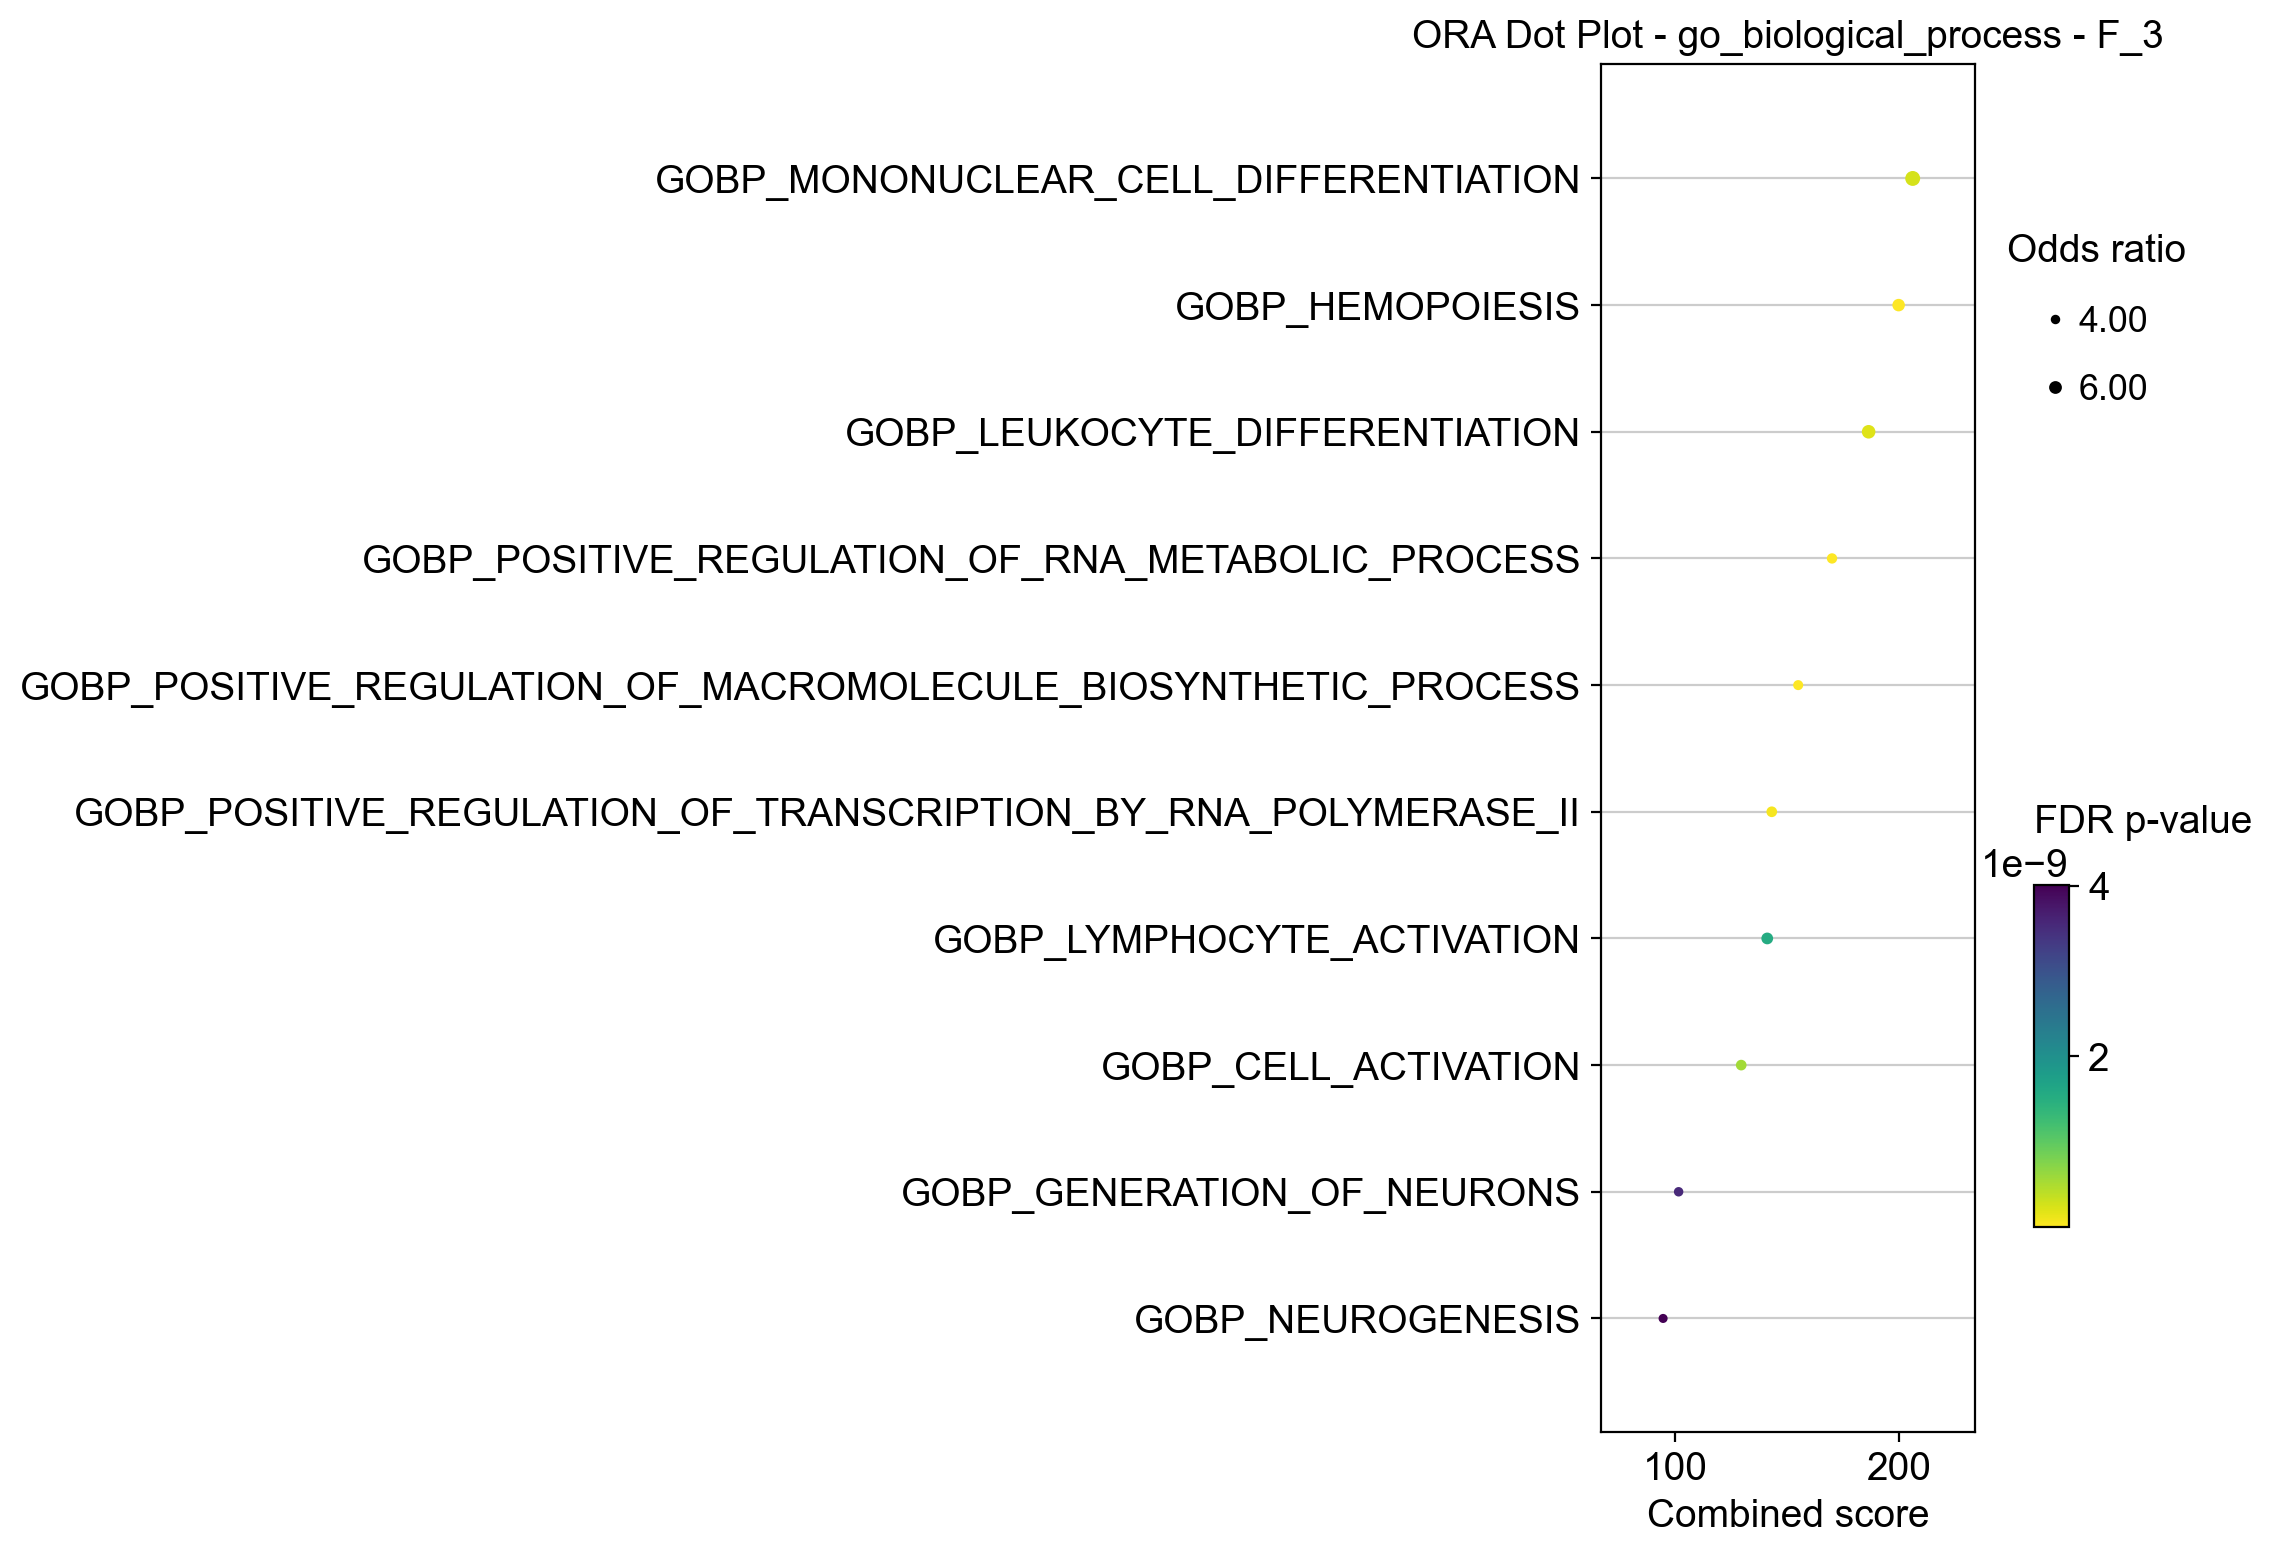

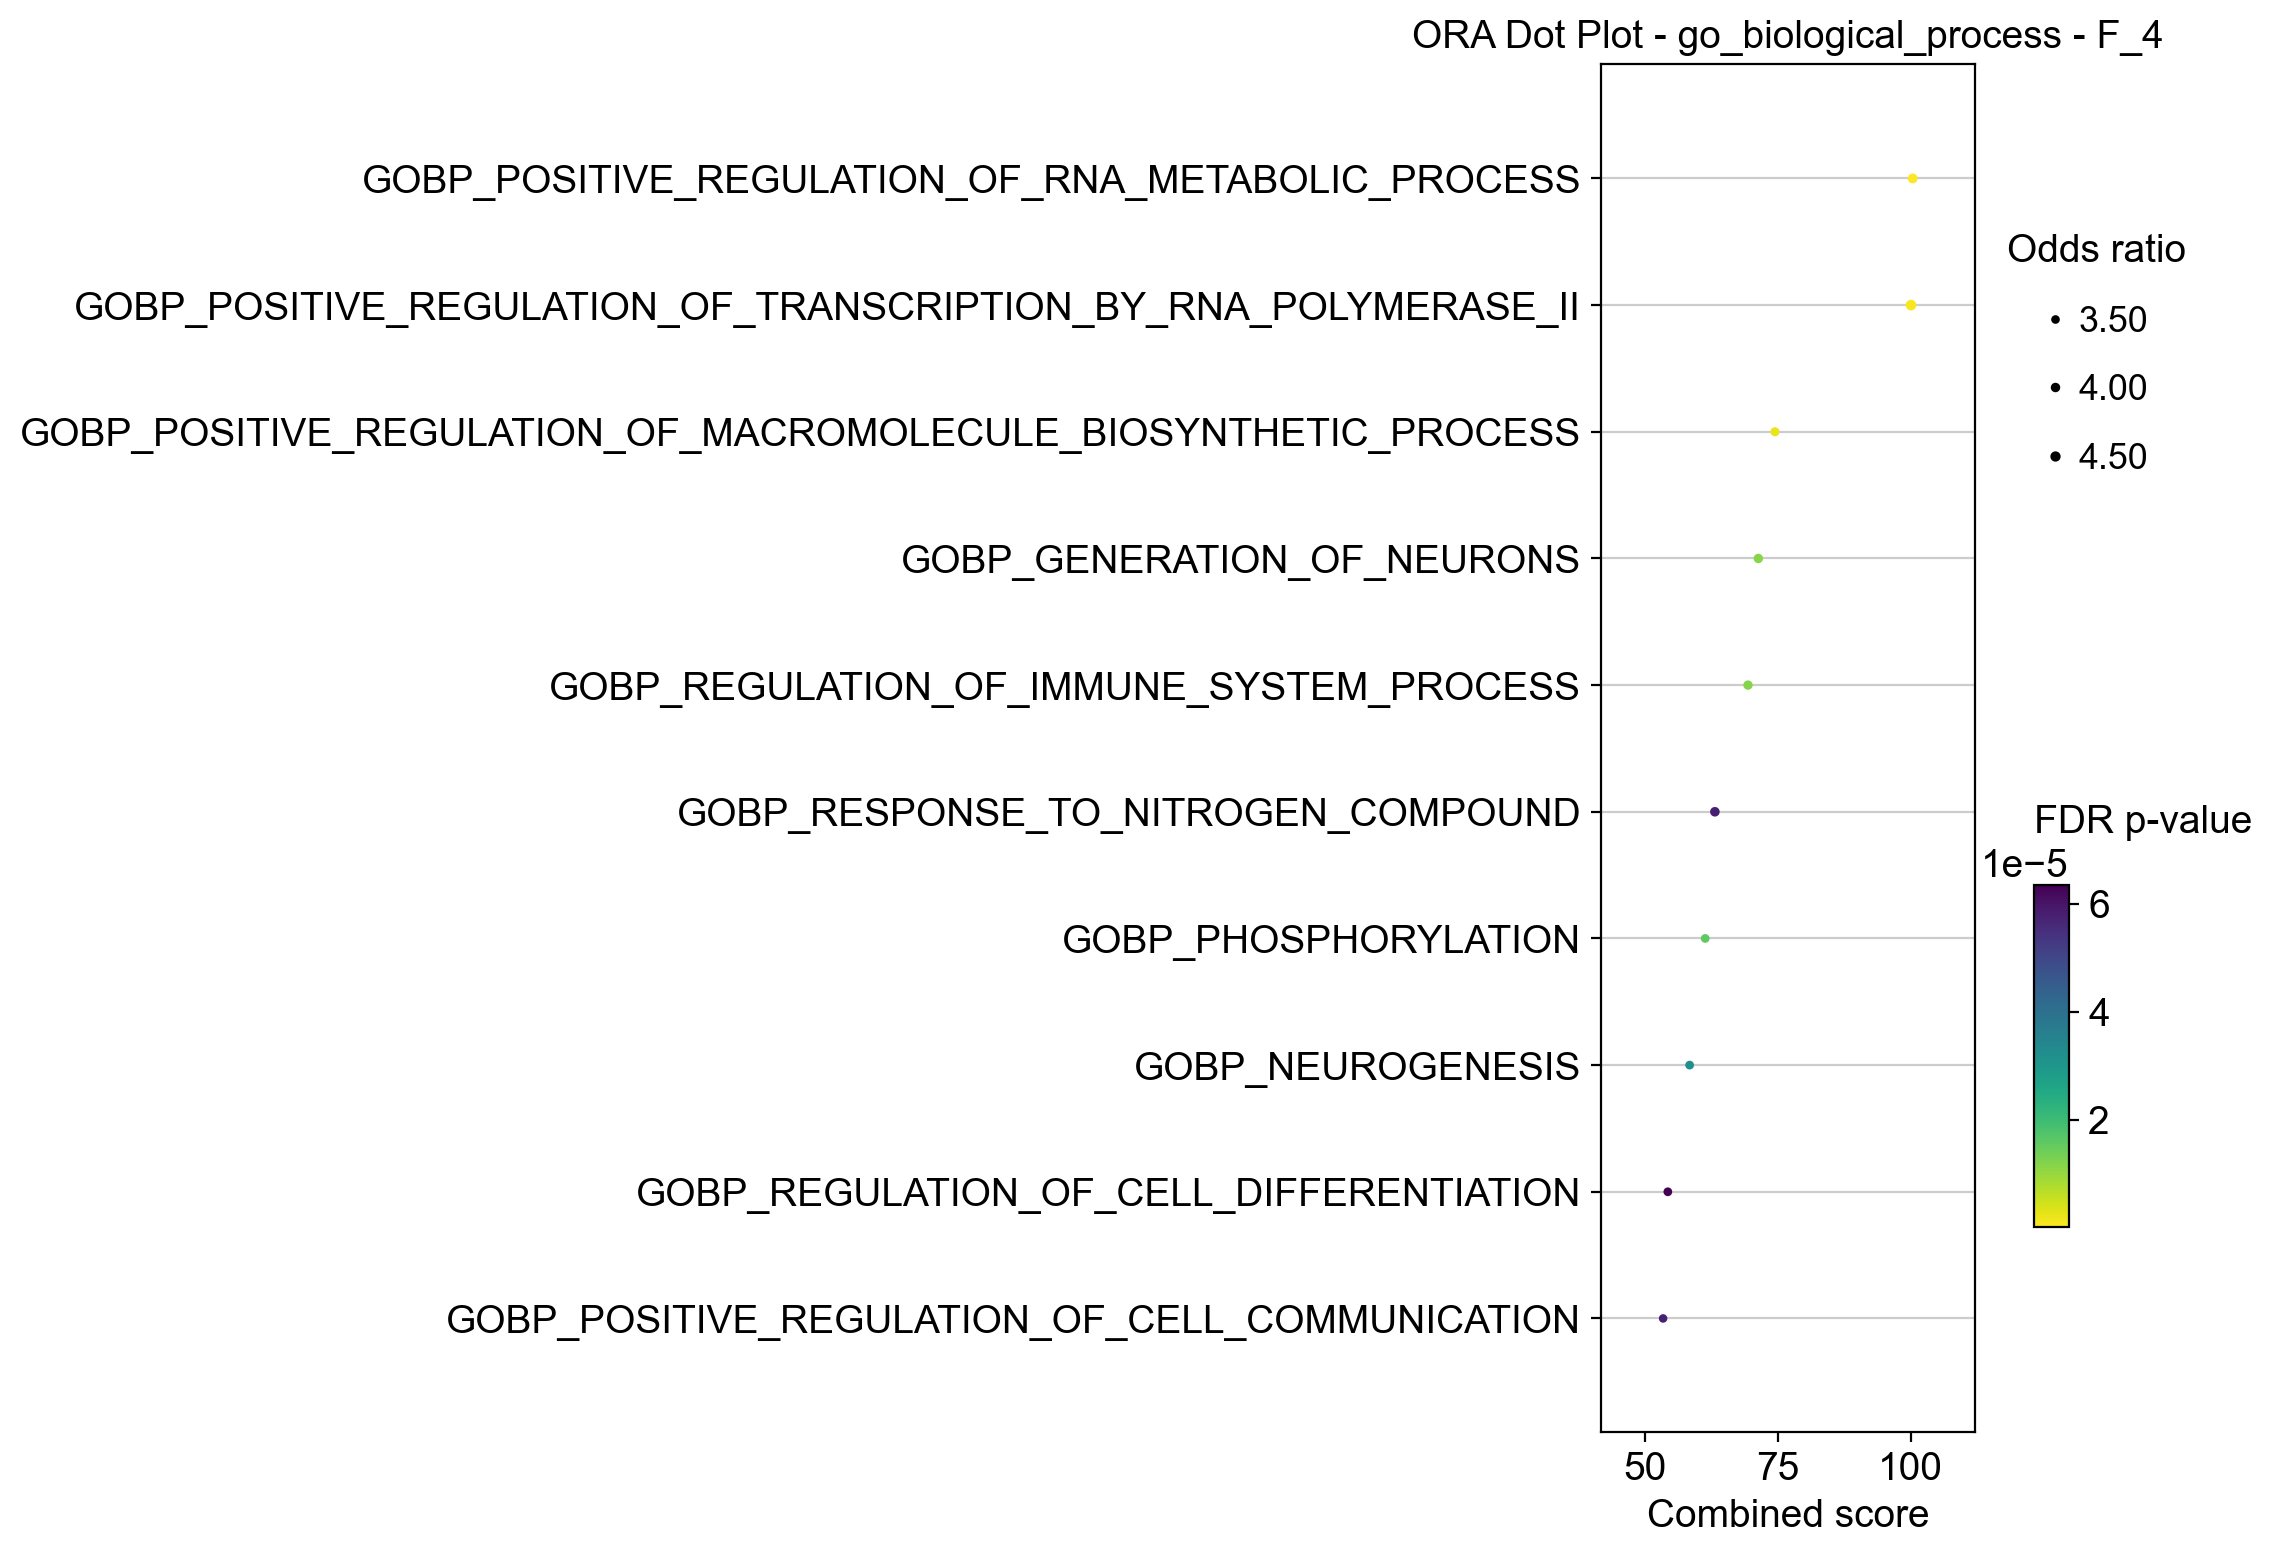

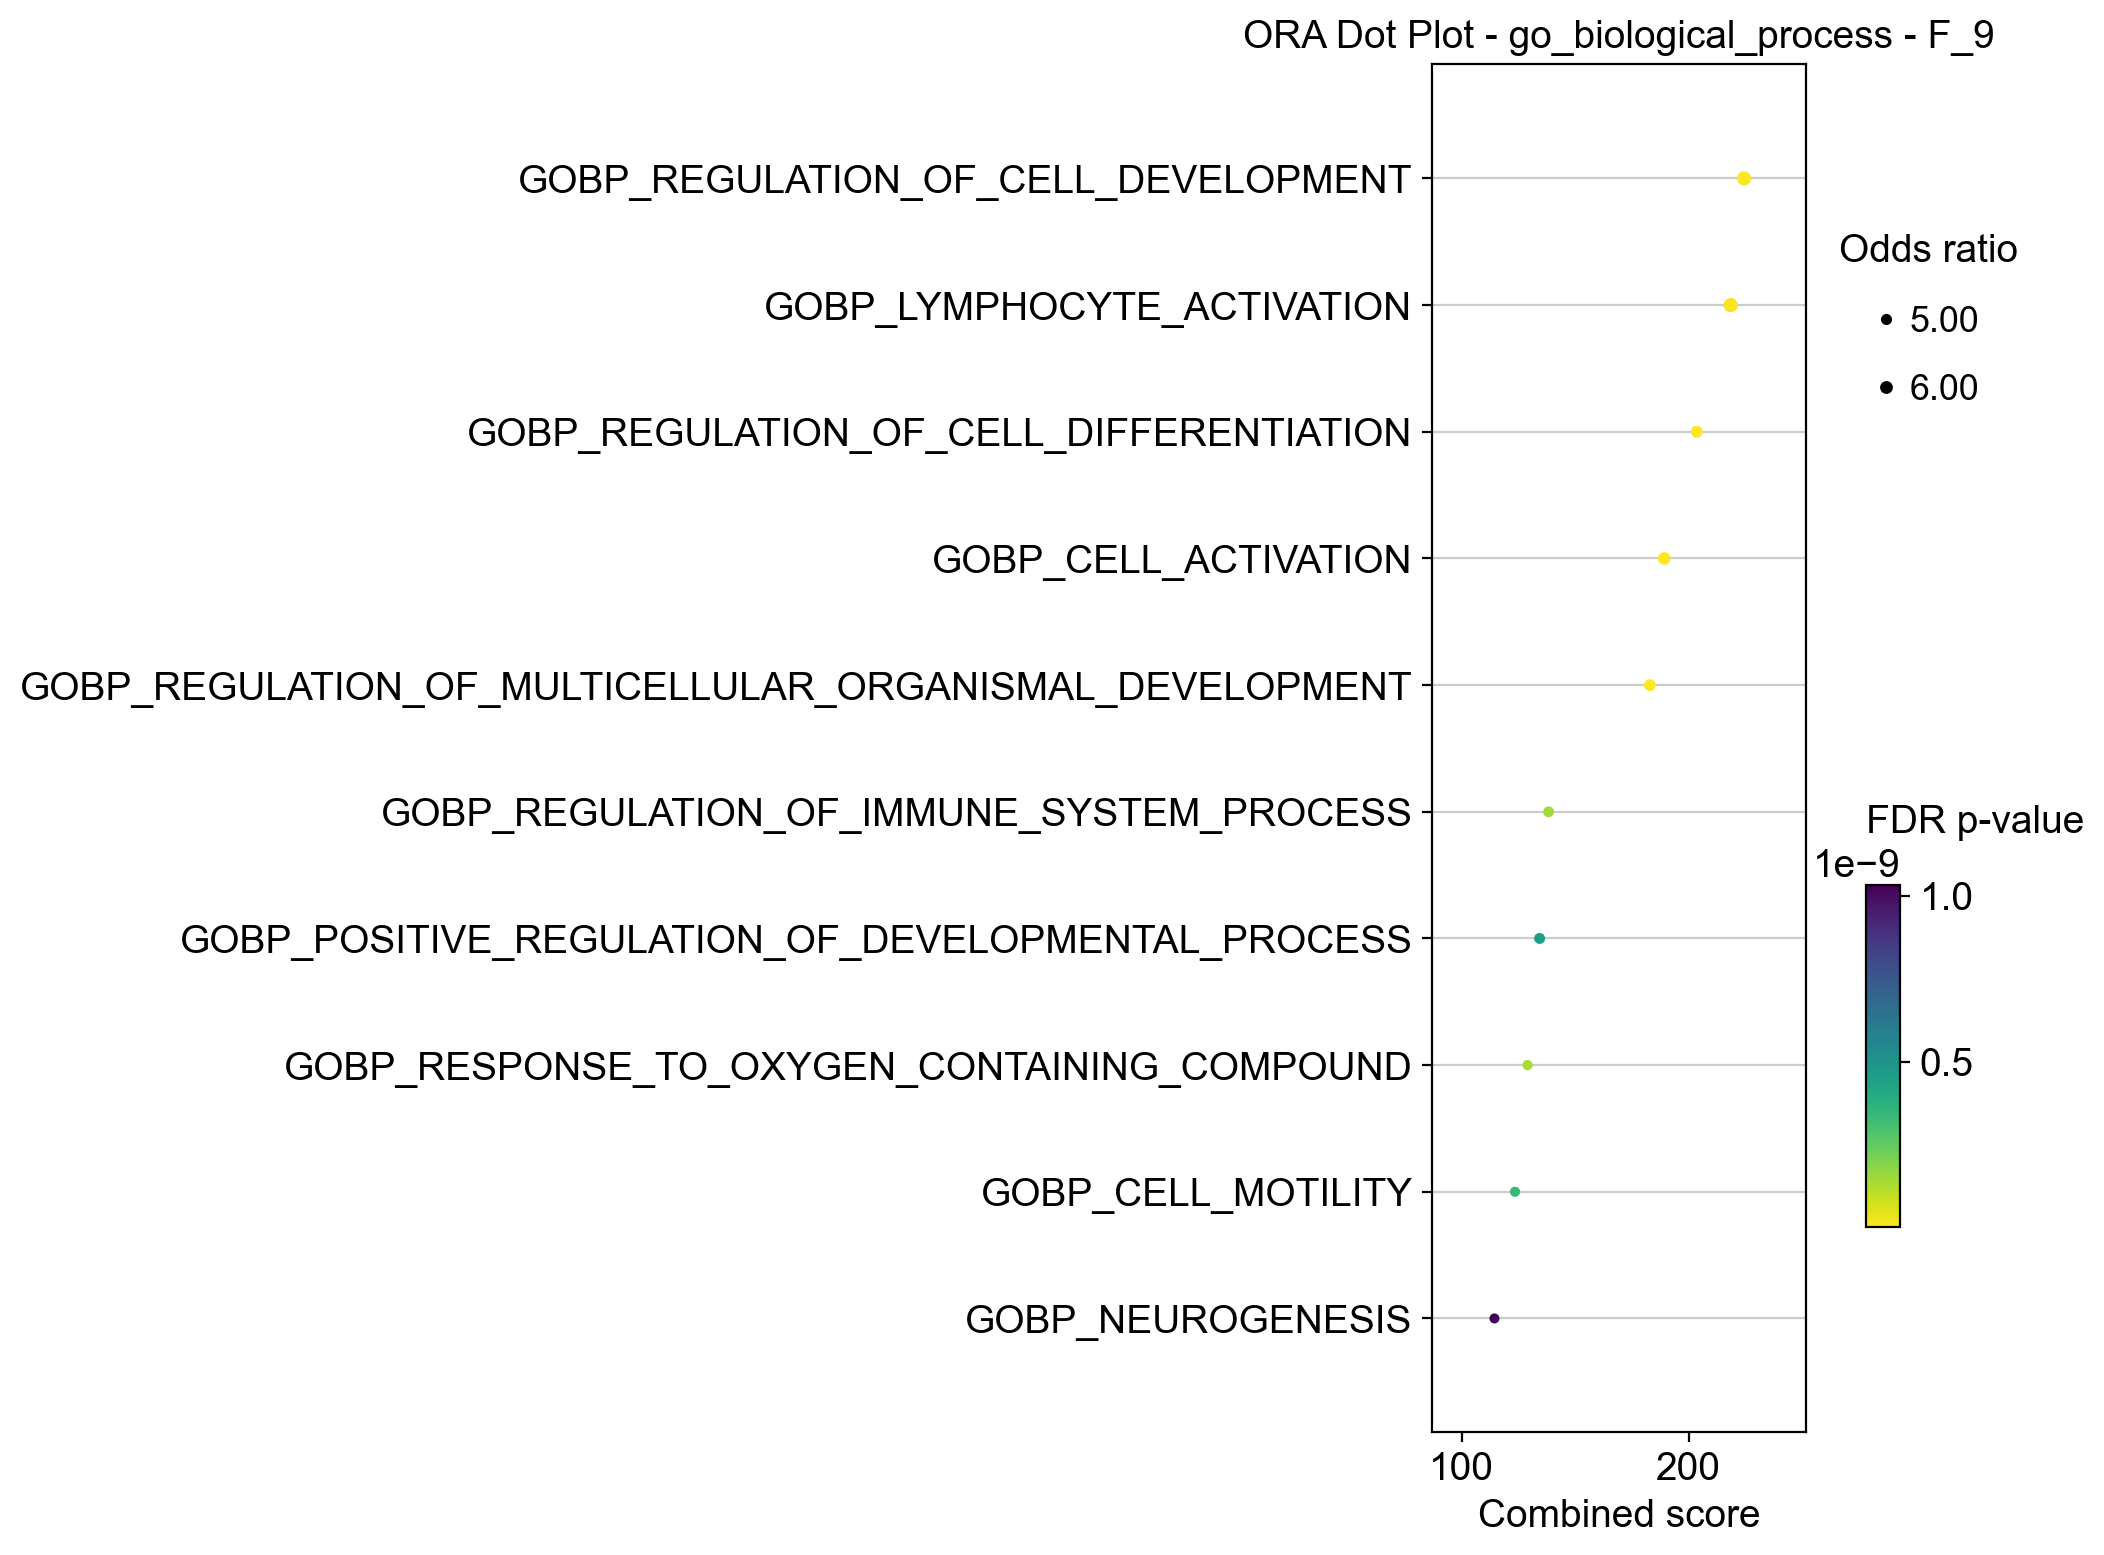

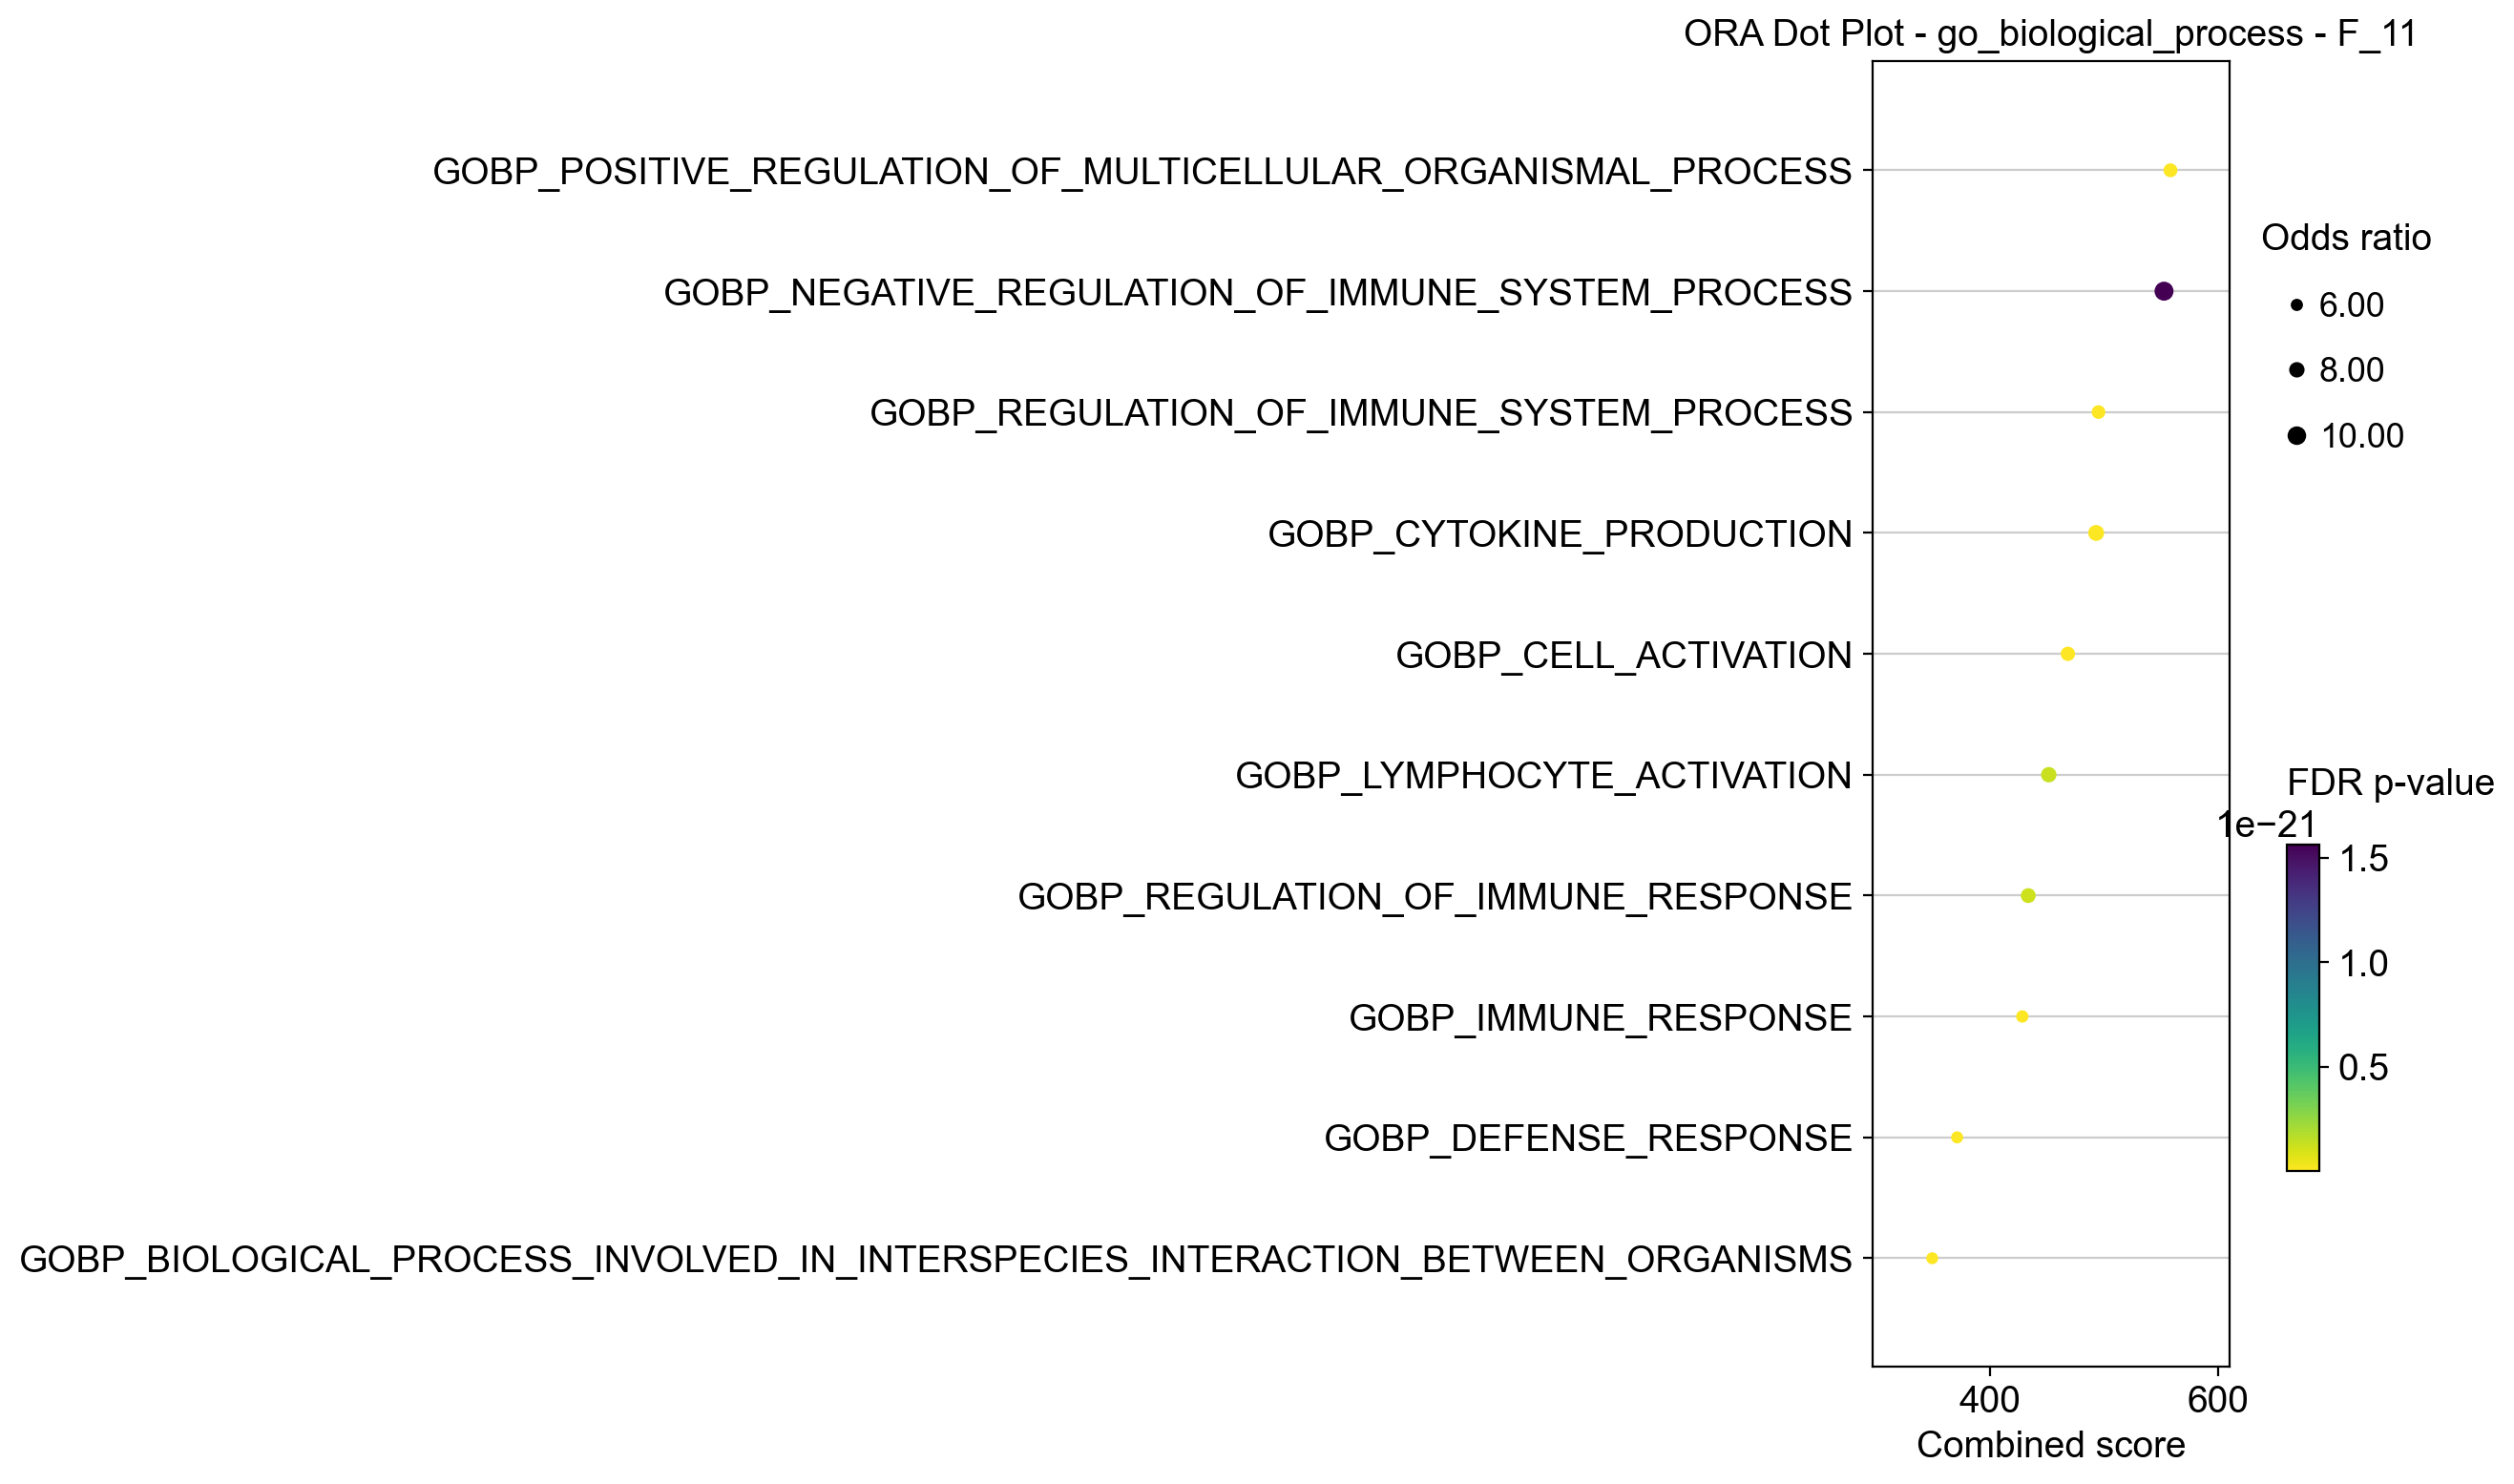

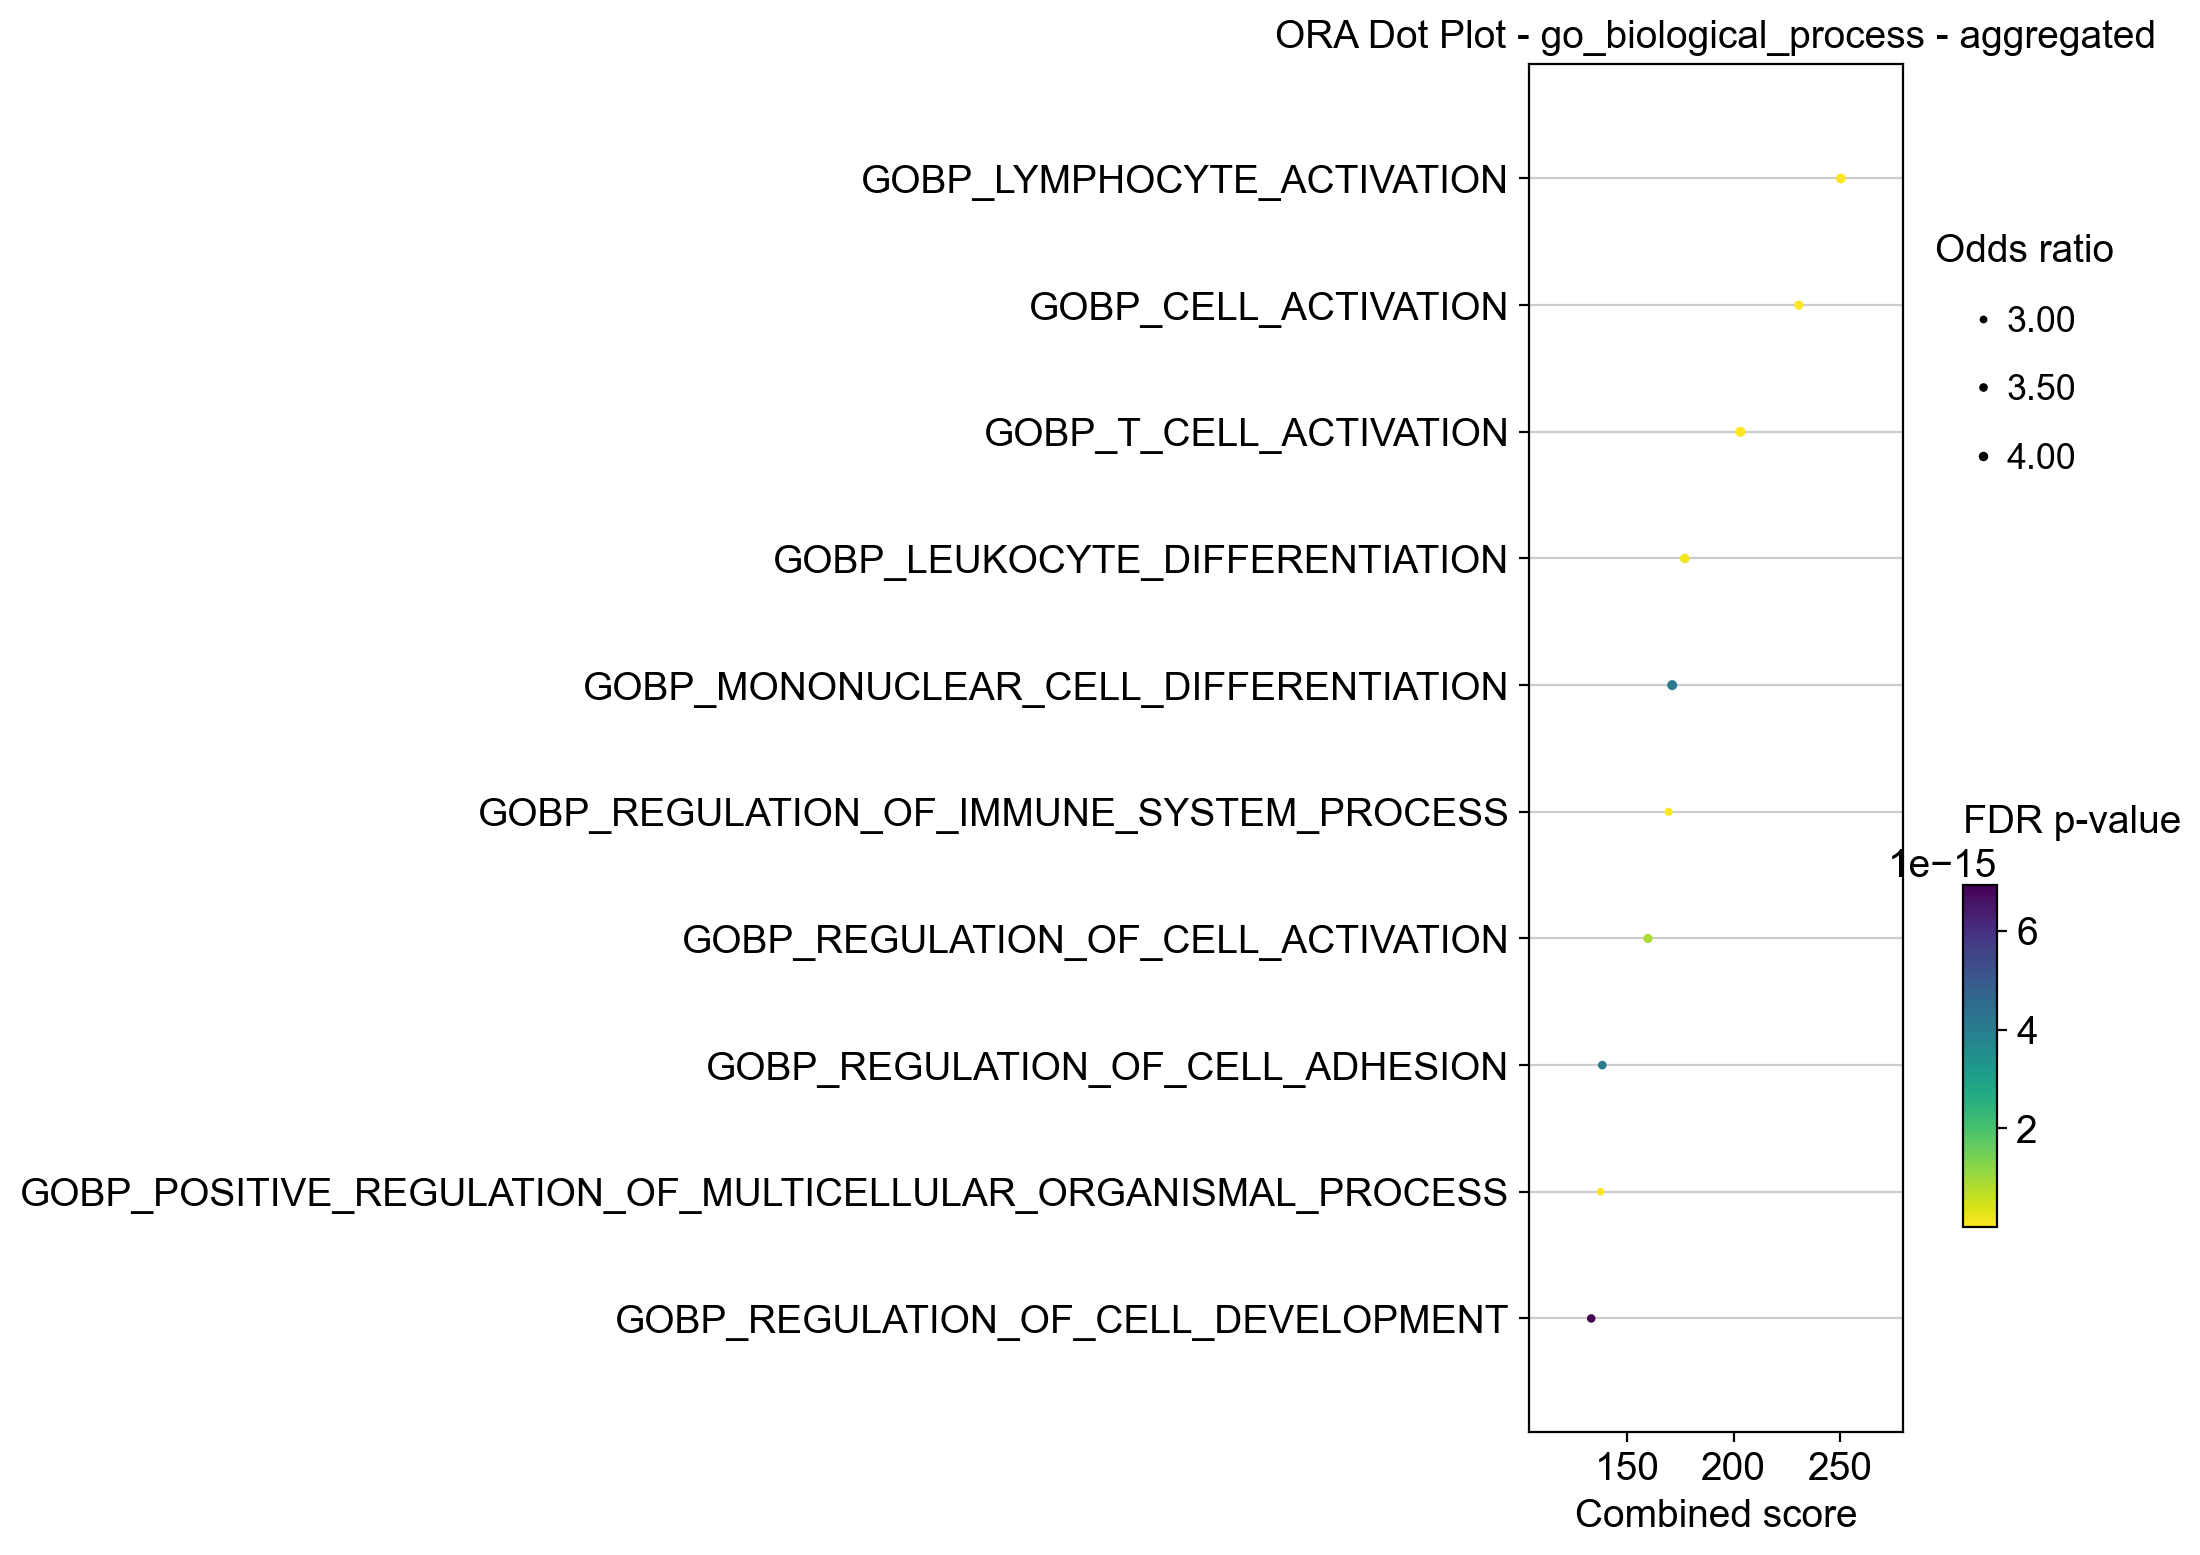

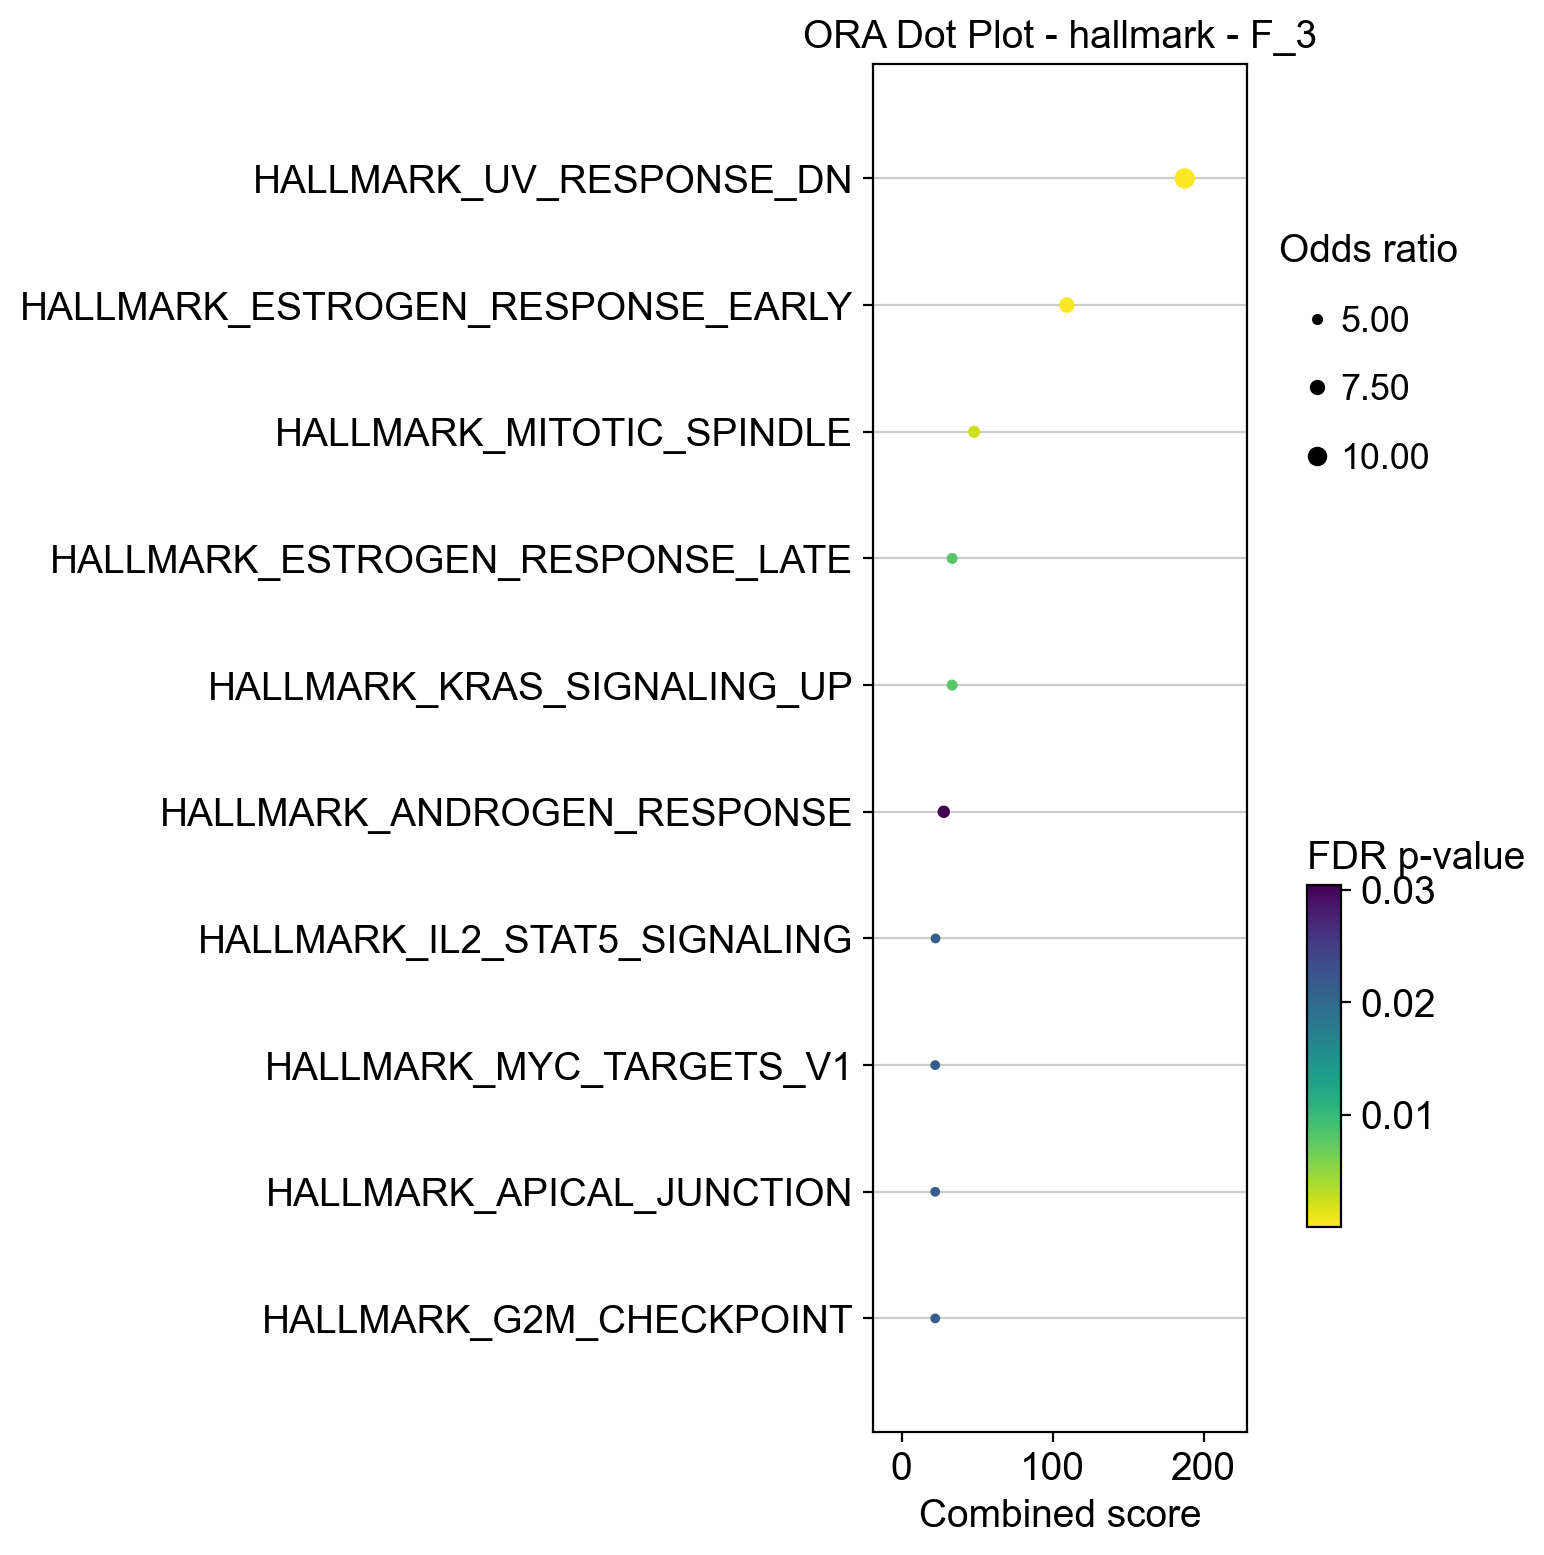

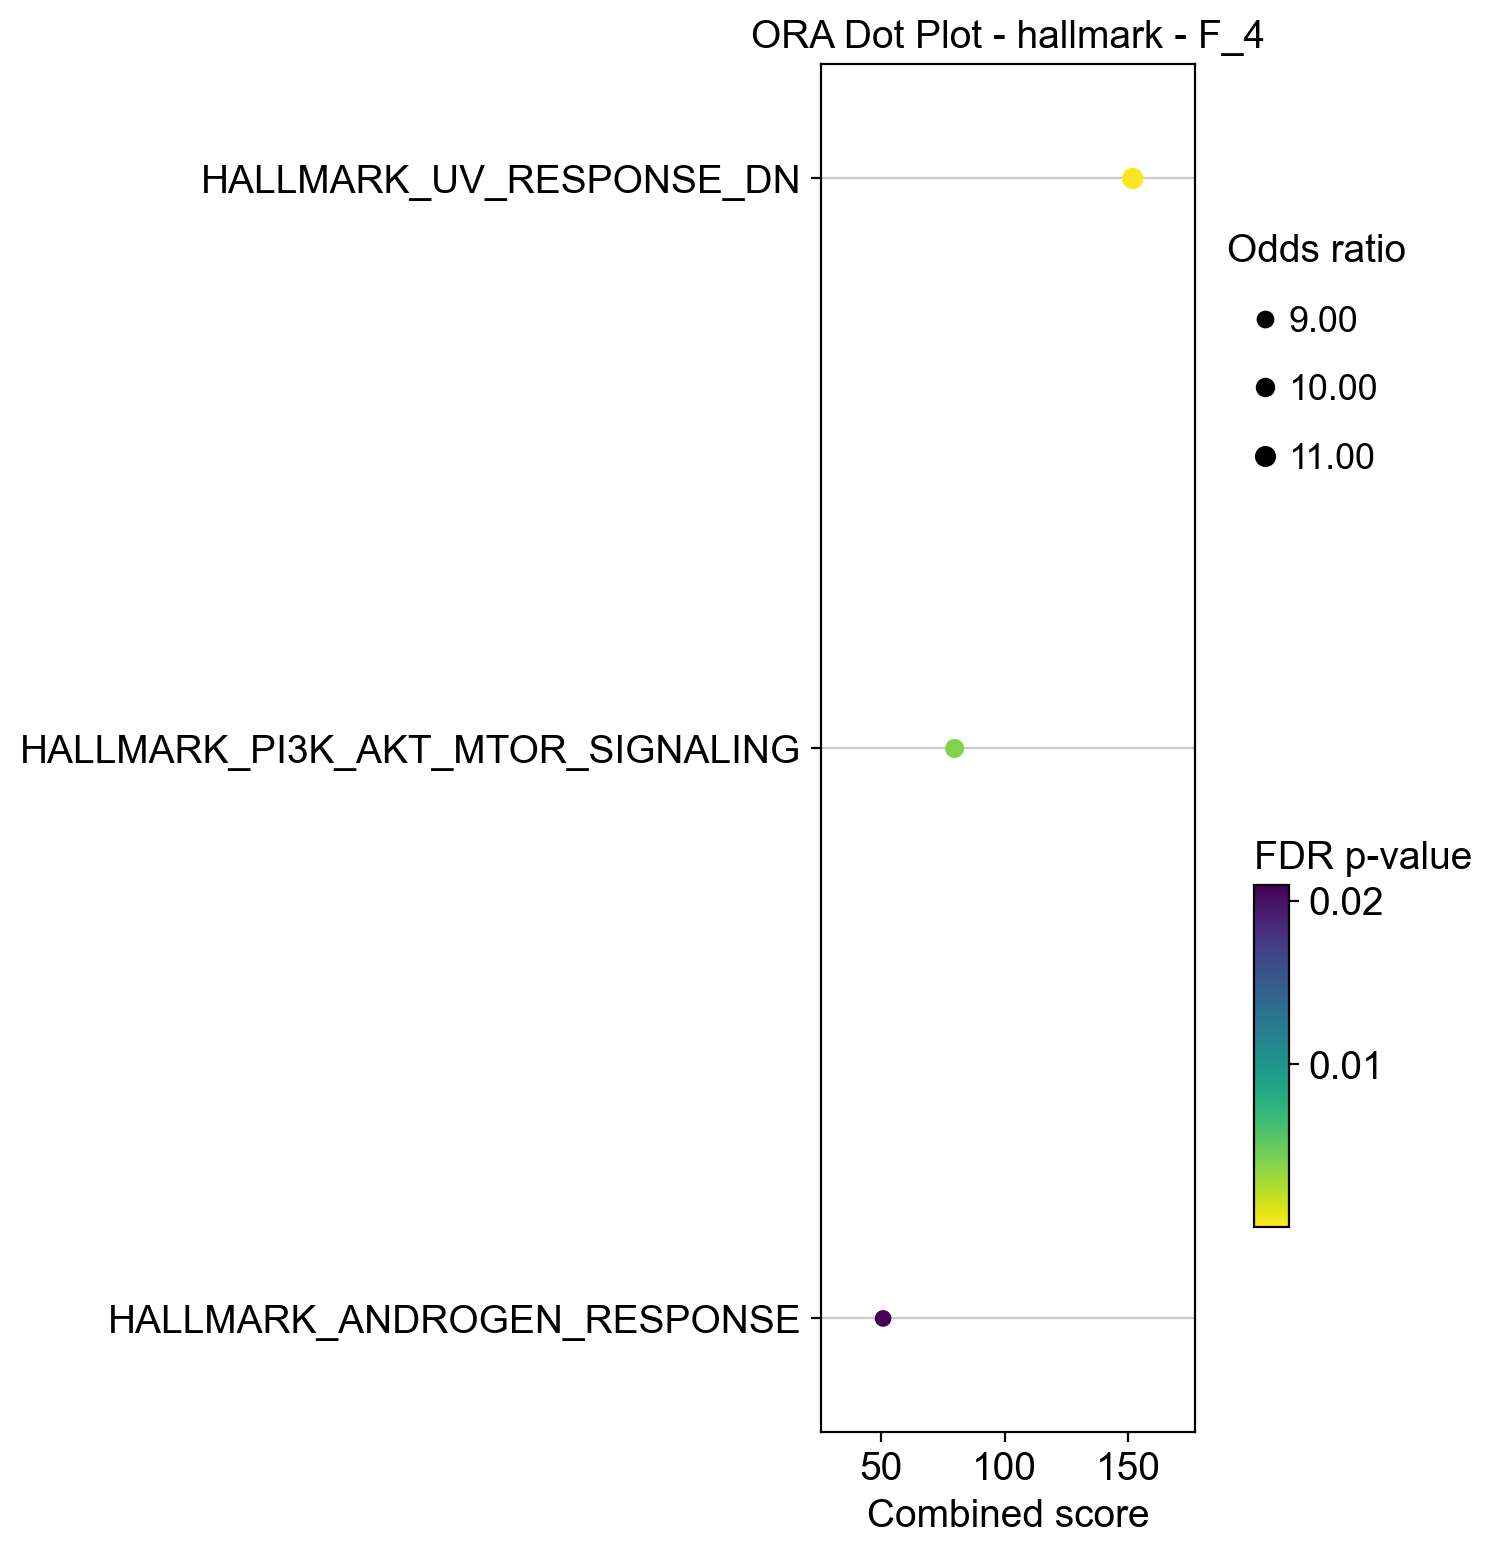

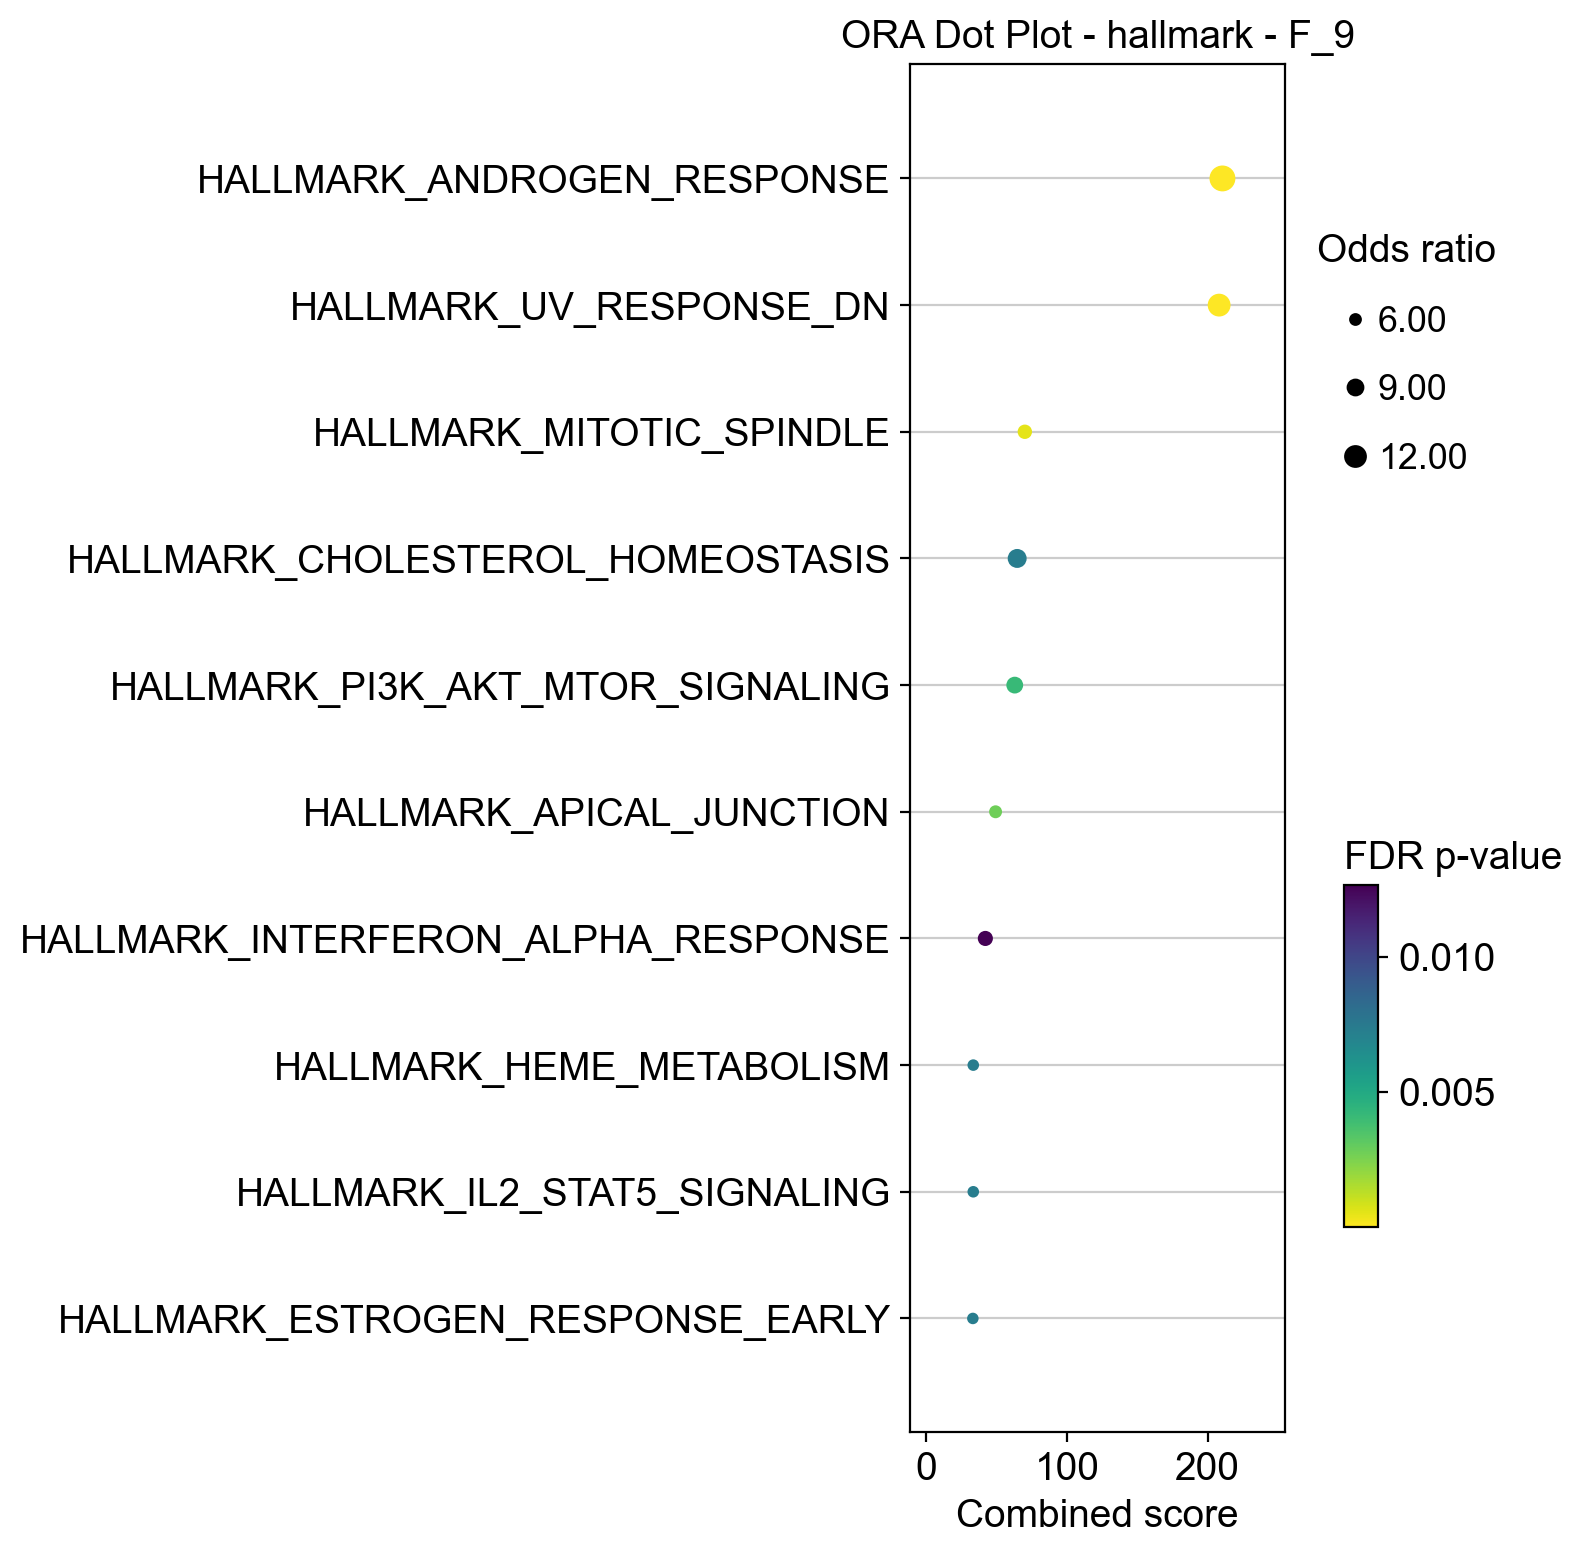

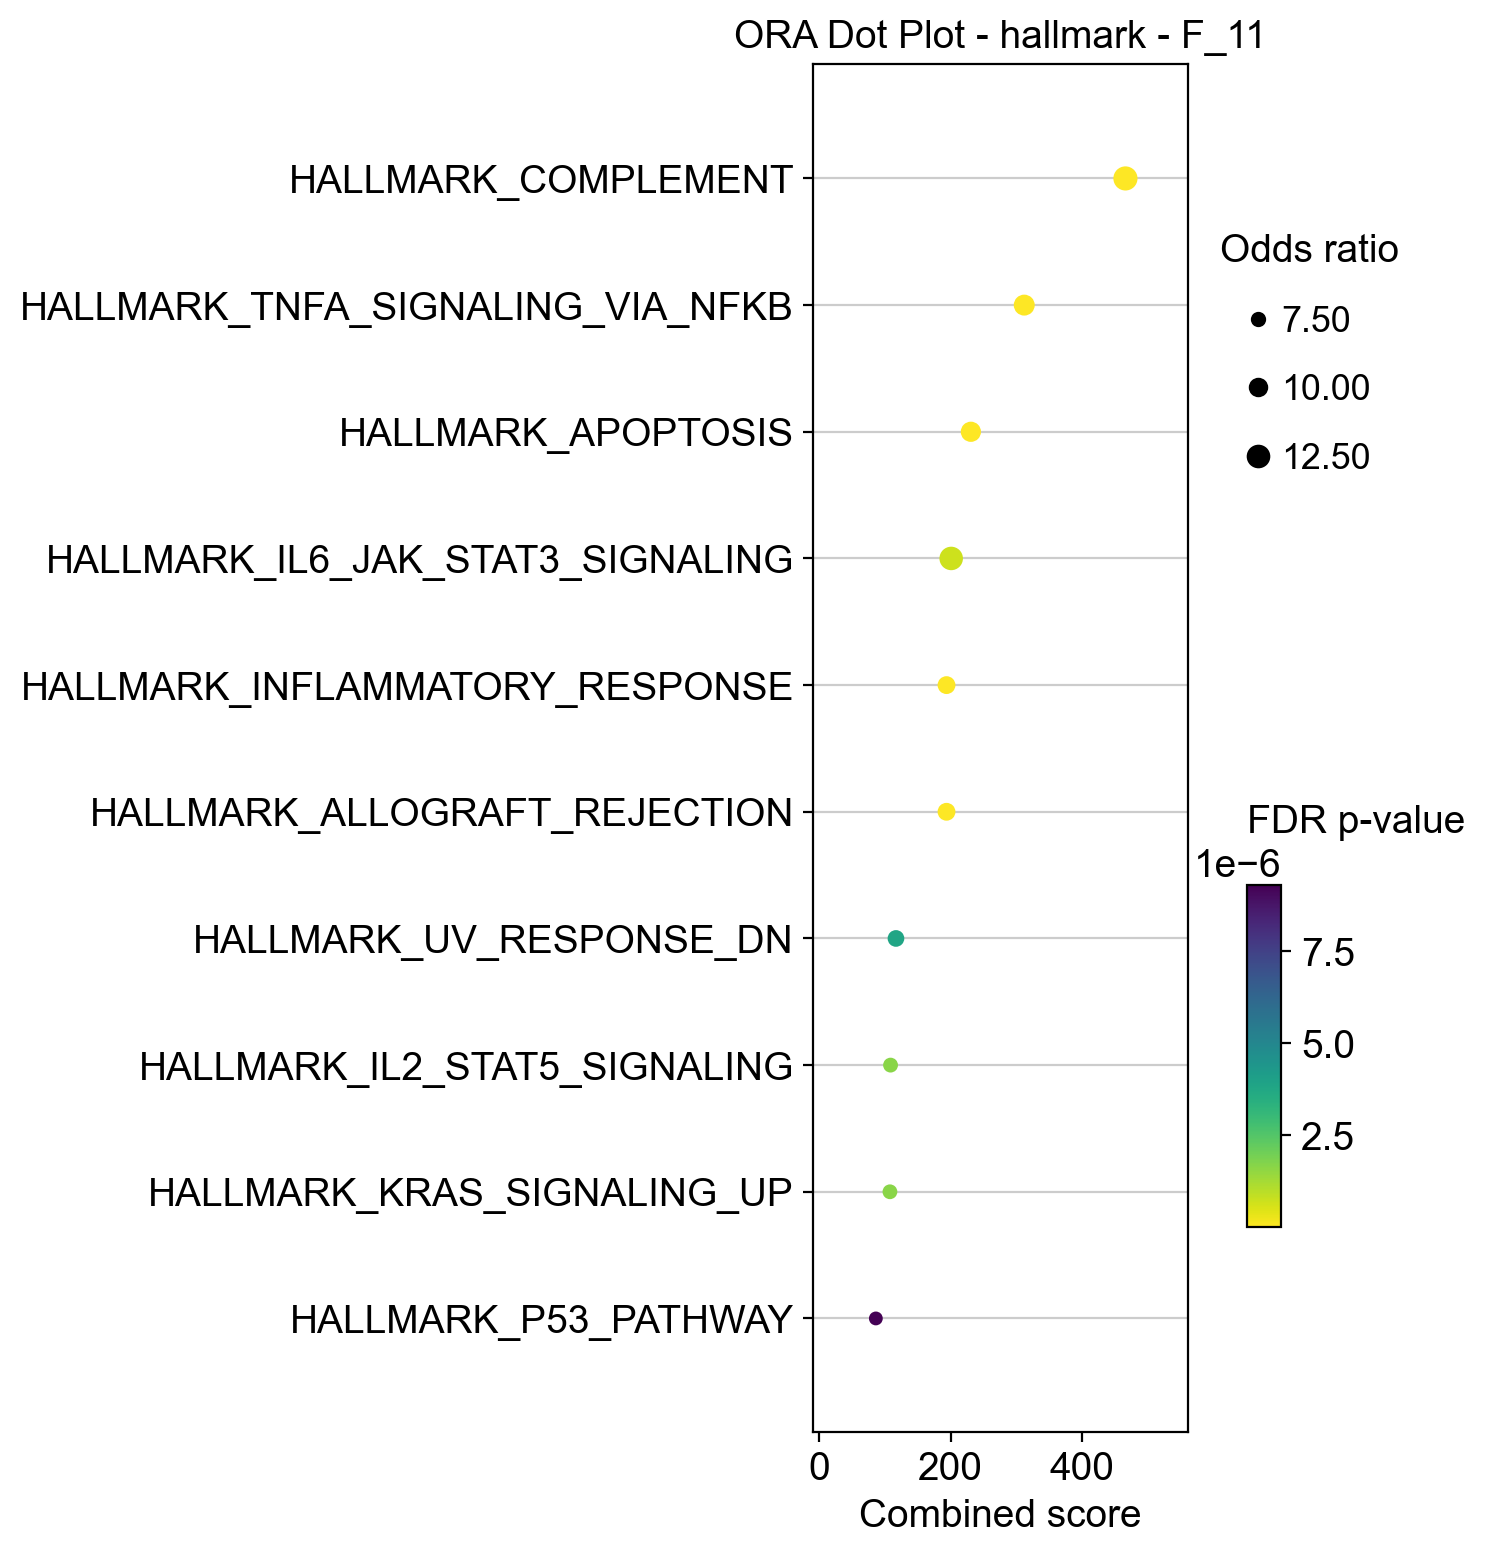

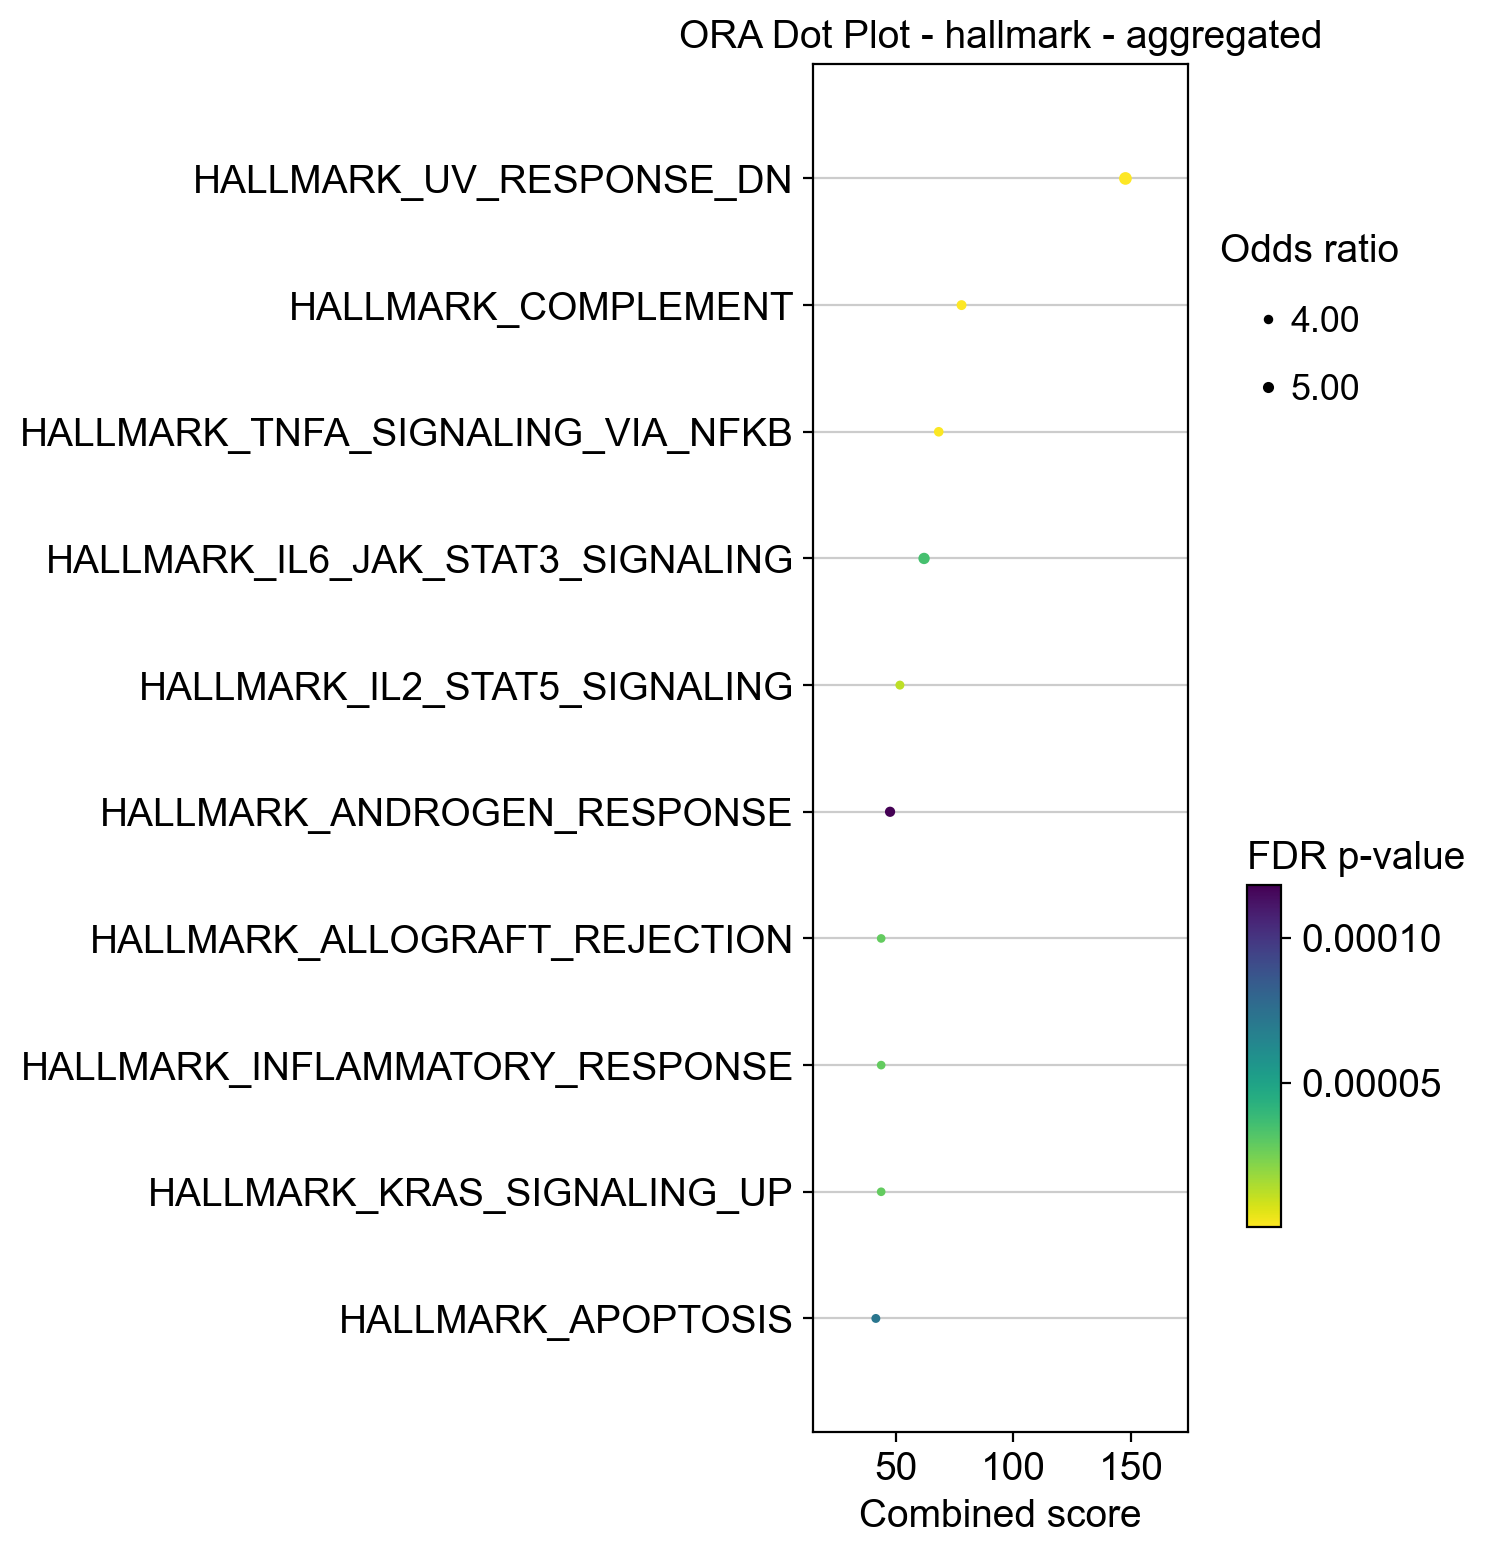

In [16]:
# iterate through each collection and its ORA results
for collection, ora_results in collection_ora_results.items():
    # iterate over each latent factor and its ORA results
    for factor, enr_pvals in ora_results.items():

        # filter significant pathways
        filtered_results = enr_pvals[enr_pvals['FDR p-value'] <= 0.05]
        
        # sort and filter the top 10 terms
        top_terms = filtered_results.sort_values('FDR p-value', ascending=True).head(10)  # 'FDR p-value', ascending=True, 'Combined score', ascending=False

        # check if there are terms to plot
        if top_terms.empty:
            print(f"No significant terms for {collection} - {factor} with FDR <= 0.05")
            continue
        
        # plot
        dc.plot_dotplot(
            top_terms,
            x='Combined score',
            y='Term',
            s='Odds ratio',
            c='FDR p-value',
            scale=0.1,
            figsize=(3, 9)
        )
            
        plt.title(f"ORA Dot Plot - {collection} - {factor}")
        plt.show()


In [18]:
# select AML cells only
aml_cell_types = [
    "AML cells 1",
    "AML cells 2",
    "AML cells 3",
    "AML cells 4",
    "AML cells 5",
    "AML cells 6",
    "AML cells 7",
    "AML cells 8",
    "AML cells 9",
    "AML cells 10"
]

adata_aml = adata[(adata.obs["sample"] == "UL") & (adata.obs["cell_type_sub_prolif_anno"].isin(aml_cell_types))].copy()

# convert to a DataFrame
counts_df = pd.DataFrame(
    adata_aml.X.toarray() if not isinstance(adata_aml.X, pd.DataFrame) else adata_aml.X,
    index = adata_aml.obs_names,
    columns = adata_aml.var_names
)


In [19]:
# select magic's solver
magic_op = magic.MAGIC(solver = "approximate")

# run magic
X_magic = magic_op.fit_transform(
    counts_df, genes = "all_genes"
)

# add inputed counts to adata
adata_aml.layers["counts_magic"] = csr_matrix(
    X_magic.astype(np.float32)
)

Calculating MAGIC...
  Running MAGIC on 11942 cells and 37733 genes.
  Calculating graph and diffusion operator...


/Users/simonasj/software/miniforge3/envs/scanpy/lib/python3.12/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculating PCA...
    Calculated PCA in 12.69 seconds.
    Calculating KNN search...
    Calculated KNN search in 35.30 seconds.
    Calculating affinities...
    Calculated affinities in 34.97 seconds.
  Calculated graph and diffusion operator in 83.96 seconds.
  Calculating imputation...
  Calculated imputation in 0.05 seconds.
Calculated MAGIC in 92.94 seconds.


In [23]:
# select genes of interst
genes_df = X_magic.loc[:,
    ["MIR181A1HG", "CDK6", "SOX4", "ATP8B4", "ARID1B", "ETV6", "FKBP5", "RUNX1","LRMDA"]
]
genes_df.loc[:, 'cell_type_sub_prolif_anno'] = adata_aml.obs['cell_type_sub_prolif_anno']
genes_df.loc[:, 'program_mapping'] = adata_aml.obs['program_mapping']

genes_df.to_csv(
    'results/gene_gene_correlation.scv',
    index = False
)